In [1]:
import numpy as np
import wfdb
import _pickle as pickle

## 대태화

In [ ]:
import sqlite3
# Attempt to inspect the uploaded file to understand its structure (binary or text-based)
file_path = './solmi/John Silver_SHC_U8A_20240905_131522.rpd'

# Read the first few bytes of the file to identify its format
with open(file_path, 'rb') as file:
    file_header = file.read(256)  # Read the first 256 bytes for analysis

file_header

# Connect to the SQLite database
db_path = './solmi/John Silver_SHC_U8A_20240905_131522.rpd'
connection = sqlite3.connect(db_path)

# Fetch table names from the database
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Close the connection for now
connection.close()

# Display the tables
tables

# Reconnect to the SQLite database
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Fetch the first few rows from the 'ecg_raw' table to inspect its structure
cursor.execute("PRAGMA table_info(ecg_raw);")  # Get column information
ecg_raw_columns = cursor.fetchall()

cursor.execute("SELECT * FROM ecg_raw LIMIT 10;")  # Fetch first 10 rows of data
ecg_raw_sample = cursor.fetchall()

# Close the connection
connection.close()

(ecg_raw_columns, ecg_raw_sample)


import pandas as pd
import matplotlib.pyplot as plt

# Reconnect to the SQLite database to extract the full 'ecg_raw' table
connection = sqlite3.connect(db_path)
query = "SELECT * FROM ecg_raw;"
ecg_raw_data = pd.read_sql_query(query, connection)
connection.close()

# Display the first few rows of the data
ecg_raw_data.head()

# Plot the data to visualize the ECG signals
plt.figure(figsize=(12, 6))
plt.plot(ecg_raw_data['ecg_index'], ecg_raw_data['ecg_ch0'], label='Channel 0')
plt.plot(ecg_raw_data['ecg_index'], ecg_raw_data['ecg_ch2'], label='Channel 2', alpha=0.7)
plt.title('ECG Raw Signal')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



## noise분석

CombinedNoise 원래

In [ ]:
import wfdb
import numpy as np
import pickle

def prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares noise data from the MIT-BIH Noise Stress Test Database (NSTDB) with noise combinations as per the TCDAE study.
    Noise combinations include Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA) noises.

    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    snr_range: Tuple indicating the SNR range (default: (-6, 18)).
    """
    # Load NSTDB (Baseline Wander, Electrode Motion, and Muscle Artifact noises)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # print(f"[INFO] Loaded baseline wander (BW) signals: shape {bw_signals.shape}")
    # print(f"[INFO] Loaded electrode motion (EM) signals: shape {em_signals.shape}")
    # print(f"[INFO] Loaded muscle artifact (MA) signals: shape {ma_signals.shape}")
# [INFO] Loaded baseline wander (BW) signals: shape (650000, 2)
# [INFO] Loaded electrode motion (EM) signals: shape (650000, 2)
# [INFO] Loaded muscle artifact (MA) signals: shape (650000, 2)
    # Initialize combined noise storage for pickle output
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Get noise data for the current channel (both BW, EM, MA)
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {em_noise.shape}, MA noise shape: {ma_noise.shape}")
        # 650000, 650000, 650000
        # Noise combination types based on Fig. 2 in the TCDAE paper (8 combinations of BW, EM, and MA)
        noise_combinations = [
            (0, 0, 0),  # Type 1: No noise
            (1, 0, 0),  # Type 2: BW only
            (0, 1, 0),  # Type 3: EM only
            (0, 0, 1),  # Type 4: MA only
            (1, 1, 0),  # Type 5: BW + EM
            (1, 0, 1),  # Type 6: BW + MA
            (0, 1, 1),  # Type 7: EM + MA
            (1, 1, 1)   # Type 8: BW + EM + MA (all noises)
        ]

        # Create a noise matrix to store all possible combinations of noises
        noise_matrix = np.zeros((bw_noise.shape[0], len(noise_combinations)))
        print(f"[DEBUG] Initialized noise matrix with shape {noise_matrix.shape}")
        # 650000, 8
        # Iterate over all noise combinations to fill the noise matrix
        for idx, (bw_flag, em_flag, ma_flag) in enumerate(noise_combinations):
            combined_noise_for_type = (
                bw_flag * bw_noise +
                em_flag * em_noise +
                ma_flag * ma_noise
            )
            noise_matrix[:, idx] = combined_noise_for_type
            # print(f"[DEBUG] Filled noise matrix for combination type {idx+1}, shape: {noise_matrix[:, idx].shape}")
            #650000
        # Append the noise matrix for this channel to the combined noise list
        combined_noise.append(noise_matrix)
        # print(f"[INFO] Combined noise for channel {channel+1} has shape {noise_matrix.shape}")
        # 650000,8
    # Save combined noise (BW, EM, MA, and their combinations) as a pickle file
    with open('data/CombinedNoise.pkl', 'wb') as output:  # Overwrites any existing file
        pickle.dump(combined_noise, output)
    # print(f'combined noise shape : {np.array(combined_noise).shape}')
    # combined noise shape : (2, 650000, 8)
    print('=========================================================')
    print('MIT BIH data noise stress test database (NSTDB) with combined noise saved as pickle')
# 채널마다 650000개의 데이터가 있고, 8가지의 노이즈 조합이 있음을 확인할 수 있습니다.


밑에껀 snr대로 한건데 , 실제 상황이 아닐듯


In [ ]:
import wfdb
import numpy as np
import pickle

def prepare_combined_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
    by applying sequential and random noise combinations to model realistic scenarios.
    Expands the final noise matrix to shape (2, 650000, 1).
    
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    """
    # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    # [INFO] Loaded baseline wander (BW) signals: shape (650000, 2)
    # [INFO] Loaded electrode motion (EM) signals: shape (650000, 2)
    # [INFO] Loaded muscle artifact (MA) signals: shape (650000, 2)
    
    # Define acceptable SNR ranges for each noise type
    snr_ranges = {
        "BW": (0, 5),  # Baseline Wander
        "EM": (10, 15),  # Electrode Motion
        "MA": (5, 10)   # Muscle Artifact
    }

    # Initialize storage for combined noise across channels
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Extract channel-specific noise data
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {ma_noise.shape}, MA noise shape: {ma_noise.shape}")
        
        # Initialize combined noise array for this channel
        combined_channel_noise = np.zeros(bw_noise.shape)

        # Divide the noise data into chunks (simulating random time intervals)
        chunk_size = 10000  # Random time chunk size
        num_chunks = len(bw_noise) // chunk_size
        seed = 1234  # 원하는 값을 설정
        np.random.seed(seed=seed)
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = start_idx + chunk_size

            # Apply random noise combinations to this chunk
            bw_flag = np.random.choice([0, 1])  # Include Baseline Wander or not
            em_flag = np.random.choice([0, 1])  # Include Electrode Motion or not
            ma_flag = np.random.choice([0, 1])  # Include Muscle Artifact or not
            
            # Generate noise for this chunk
            chunk_noise = (
                bw_flag * adjust_snr(bw_noise[start_idx:end_idx], snr_ranges["BW"]) +
                em_flag * adjust_snr(em_noise[start_idx:end_idx], snr_ranges["EM"]) +
                ma_flag * adjust_snr(ma_noise[start_idx:end_idx], snr_ranges["MA"])
            )

            # Random scaling factor for added realism
            # scale_factor = np.random.uniform(0.5, 1.5)
            # chunk_noise *= scale_factor

            # Apply the chunk noise to the combined noise array
            combined_channel_noise[start_idx:end_idx] += chunk_noise
        
        # Expand dimensions to make it (650000, 1) for this channel
        combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)

        # Append the combined noise for this channel
        combined_noise.append(combined_channel_noise)

    # Stack the noises for all channels to shape (2, 650000, 1)
    combined_noise = np.stack(combined_noise, axis=0)

    # Save combined noise data as a pickle file
    with open('data/CombinedNoise.pkl', 'wb') as output:
        pickle.dump(combined_noise, output)
    
    print('=========================================================')
    print(f'Final combined noise shape: {combined_noise.shape}')
    print('Realistic NSTDB noise data with combined scenarios saved as pickle')

def adjust_snr(noise, snr_range):
    """
    Adjusts the noise level to match the given SNR range.

    Parameters:
    noise: The original noise signal.
    snr_range: Tuple specifying the desired SNR range (min, max).

    Returns:
    Adjusted noise signal.
    """
    target_snr = np.random.uniform(*snr_range)  # Randomly select SNR from the given range
    signal_power = np.mean(noise**2)
    noise_power = signal_power / (10**(target_snr / 10))
    noise_std = np.sqrt(noise_power)
    
    # Scale the noise to match the target SNR
    adjusted_noise = noise / np.std(noise) * noise_std
    return adjusted_noise


이게 진짜

In [50]:
import wfdb
import numpy as np
import pickle

def prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
    with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
    Muscle Artifact (MA) noises are added randomly.
    Expands the final noise matrix to shape (2, 650000, 1).
    
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    """
    # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Initialize storage for combined noise across channels
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Extract channel-specific noise data
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {ma_noise.shape}, MA noise shape: {ma_noise.shape}")
        
        # Initialize combined noise array for this channel
        combined_channel_noise = np.zeros(bw_noise.shape)

        # Divide the noise data into chunks (simulating random time intervals)
        chunk_size = 10000  # Random time chunk size
        num_chunks = len(bw_noise) // chunk_size
        seed = 1234  # 원하는 값을 설정
        np.random.seed(seed=seed)
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = start_idx + chunk_size

            # Include BW noise by default
            bw_chunk = bw_noise[start_idx:end_idx]

            # Randomly decide whether to include EM and MA noises
            em_flag = np.random.choice([0, 1])  # Include Electrode Motion or not
            ma_flag = np.random.choice([0, 1])  # Include Muscle Artifact or not
            
            # Generate noise for this chunk
            chunk_noise = (
                bw_chunk +  # BW noise is always included
                em_flag * em_noise[start_idx:end_idx] +
                ma_flag * ma_noise[start_idx:end_idx]
            )

            # Apply the chunk noise to the combined noise array
            combined_channel_noise[start_idx:end_idx] += chunk_noise
        
        # Expand dimensions to make it (650000, 1) for this channel
        combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)

        # Append the combined noise for this channel
        combined_noise.append(combined_channel_noise)

    # Stack the noises for all channels to shape (2, 650000, 1)
    combined_noise = np.stack(combined_noise, axis=0)

    # Save combined noise data as a pickle file
    with open('data/CombinedNoise.pkl', 'wb') as output:
        pickle.dump(combined_noise, output)
    
    print('=========================================================')
    print(f'Final combined noise shape: {combined_noise.shape}')
    print('Realistic NSTDB noise data with Baseline Wander always included saved as pickle')


In [51]:
prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

[DEBUG] Processing channel 1: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
[DEBUG] Processing channel 2: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
Final combined noise shape: (2, 650000, 1)
Realistic NSTDB noise data with Baseline Wander always included saved as pickle


BW Noise Shape: (650000, 2)
EM Noise Shape: (650000, 2)
MA Noise Shape: (650000, 2)
Combined Noise Shape: (2, 650000, 1)


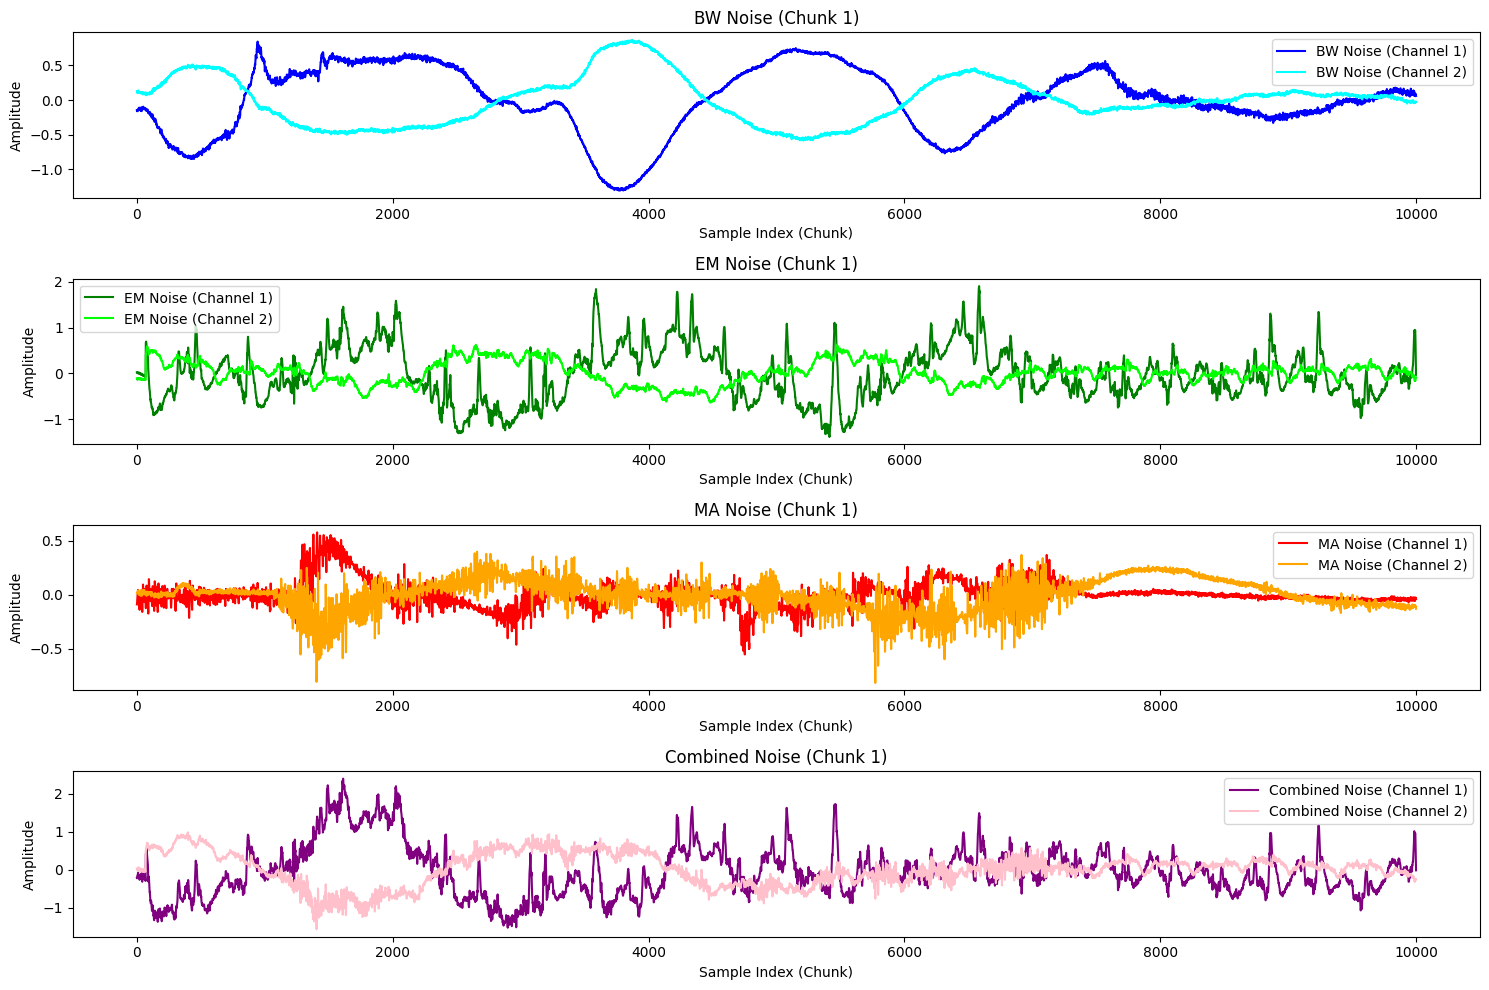

In [18]:
import wfdb
import numpy as np
import pickle
import matplotlib.pyplot as plt

def visualize_single_chunk(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000, chunk_idx=0):
    """
    Visualizes a single chunk of noise signals:
    - Baseline Wander (BW) noise
    - Electrode Motion (EM) noise
    - Muscle Artifact (MA) noise
    - Combined Noise

    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    chunk_size: Number of samples per chunk.
    chunk_idx: Index of the chunk to visualize.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Load combined noise matrix
    with open('data/CombinedNoise.pkl', 'rb') as f:
        combined_noise = pickle.load(f)

    print(f"BW Noise Shape: {bw_signals.shape}")
    print(f"EM Noise Shape: {em_signals.shape}")
    print(f"MA Noise Shape: {ma_signals.shape}")
    print(f"Combined Noise Shape: {combined_noise.shape}")

    # Calculate start and end indices for the chunk
    start_idx = chunk_idx * chunk_size
    end_idx = start_idx + chunk_size
    x = np.arange(chunk_size)  # Chunk x-axis

    plt.figure(figsize=(15, 10))

    # Baseline Wander Noise
    plt.subplot(4, 1, 1)
    plt.plot(x, bw_signals[start_idx:end_idx, 0], label='BW Noise (Channel 1)', color='blue')
    plt.plot(x, bw_signals[start_idx:end_idx, 1], label='BW Noise (Channel 2)', color='cyan')
    plt.title(f"BW Noise (Chunk {chunk_idx + 1})")
    plt.xlabel("Sample Index (Chunk)")
    plt.ylabel("Amplitude")
    plt.legend()

    # Electrode Motion Noise
    plt.subplot(4, 1, 2)
    plt.plot(x, em_signals[start_idx:end_idx, 0], label='EM Noise (Channel 1)', color='green')
    plt.plot(x, em_signals[start_idx:end_idx, 1], label='EM Noise (Channel 2)', color='lime')
    plt.title(f"EM Noise (Chunk {chunk_idx + 1})")
    plt.xlabel("Sample Index (Chunk)")
    plt.ylabel("Amplitude")
    plt.legend()

    # Muscle Artifact Noise
    plt.subplot(4, 1, 3)
    plt.plot(x, ma_signals[start_idx:end_idx, 0], label='MA Noise (Channel 1)', color='red')
    plt.plot(x, ma_signals[start_idx:end_idx, 1], label='MA Noise (Channel 2)', color='orange')
    plt.title(f"MA Noise (Chunk {chunk_idx + 1})")
    plt.xlabel("Sample Index (Chunk)")
    plt.ylabel("Amplitude")
    plt.legend()

    # Combined Noise
    plt.subplot(4, 1, 4)
    plt.plot(x, combined_noise[0][start_idx:end_idx, 0], label='Combined Noise (Channel 1)', color='purple')
    plt.plot(x, combined_noise[1][start_idx:end_idx, 0], label='Combined Noise (Channel 2)', color='pink')
    plt.title(f"Combined Noise (Chunk {chunk_idx + 1})")
    plt.xlabel("Sample Index (Chunk)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function to visualize a single chunk
visualize_single_chunk(chunk_size=10000, chunk_idx=0)


In [5]:
import wfdb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal import resample

def visualize_and_save_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000, save_path='images/'):
    """
    Visualizes and saves plots for:
    - Full BW, EM, MA signals with masking for non-included chunks.
    - Combined noise for a single chunk.

    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    chunk_size: Number of samples per chunk.
    save_path: Path to save the figures.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Resample signals to 360 Hz
    def resample_signal(signal, target_fs=360, original_fs=128):
        return resample(signal, int(len(signal) * (target_fs / original_fs)))

    bw_noise = resample_signal(bw_signals[:, 0])
    em_noise = resample_signal(em_signals[:, 0])
    ma_noise = resample_signal(ma_signals[:, 0])

    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as f:
        combined_noise = pickle.load(f)
    combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

    # Define chunks
    num_chunks = len(bw_noise) // chunk_size
    x = np.arange(len(bw_noise))
    chunks = np.array_split(x, num_chunks)
    
    # Random flags for EM and MA inclusion
    em_flags = np.random.choice([0, 1], size=num_chunks)
    ma_flags = np.random.choice([0, 1], size=num_chunks)

    # Plot BW Noise
    plt.figure(figsize=(15, 5))
    plt.plot(x, bw_noise, color='blue')
    plt.title("Baseline Wander (BW) Noise")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.savefig(f"{save_path}bw_noise.png")
    plt.close()
    
    # Plot EM Noise
    plt.figure(figsize=(15, 5))
    plt.plot(x, em_noise, color='green')
    # plt.title("Electrode Motion (EM) Noise")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    plt.axis('off')  # 축과 테두리를 모두 숨김
    plt.savefig(f"{save_path}em2_noise.png")
    plt.close()    
    
    # Plot MA Noise
    plt.figure(figsize=(15, 5))
    plt.plot(x, ma_noise, color='red')
    # plt.title("Muscle Artifact (MA) Noise")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    plt.axis('off')  # 축과 테두리를 모두 숨김
    plt.savefig(f"{save_path}ma2_noise.png")
    plt.close()
    # # Plot EM Noise
    # plt.figure(figsize=(15, 5))
    # for idx, chunk in enumerate(chunks):
    #     if em_flags[idx] == 1:
    #         plt.plot(chunk, em_noise[chunk], color='green')
    #     else:
    #         plt.plot(chunk, em_noise[chunk], color='lightgray')
    # plt.title("Electrode Motion (EM) Noise")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    # plt.savefig(f"{save_path}em_noise.png")
    # plt.close()

    # # Plot MA Noise
    # plt.figure(figsize=(15, 5))
    # for idx, chunk in enumerate(chunks):
    #     if ma_flags[idx] == 1:
    #         plt.plot(chunk, ma_noise[chunk], color='red')
    #     else:
    #         plt.plot(chunk, ma_noise[chunk], color='lightgray')
    # plt.title("Muscle Artifact (MA) Noise")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    # plt.savefig(f"{save_path}ma_noise.png")
    # plt.close()

    # Plot Combined Noise
    plt.figure(figsize=(15, 5))
    plt.plot(x[:chunk_size], combined_resampled[:chunk_size], color='purple')
    plt.title("Combined Noise for First Chunk")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.savefig(f"{save_path}combined_noise.png")
    plt.close()

    print("Plots saved successfully!")

# Call the function to visualize and save
visualize_and_save_noise(chunk_size=10000, save_path='images/')


Plots saved successfully!


In [1]:
import wfdb
import numpy as np
import pickle
import matplotlib.pyplot as plt

def visualize_with_district_lines(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000):
    """
    Visualizes the entire noise signals with district lines for chunks:
    - Baseline Wander (BW) noise (always visible)
    - Electrode Motion (EM) noise (masked in gray for unselected chunks)
    - Muscle Artifact (MA) noise (masked in gray for unselected chunks)
    - Combined Noise

    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    chunk_size: Number of samples per chunk.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Load combined noise matrix
    with open('data/CombinedNoise.pkl', 'rb') as f:
        combined_noise = pickle.load(f)

    # Determine the number of chunks based on the total length and chunk size
    total_samples = bw_signals.shape[0]
    num_chunks = total_samples // chunk_size
    x = np.arange(total_samples)  # X-axis for the entire length

    # Generate random flags for EM and MA visibility simulation (for demonstration)
    np.random.seed(1234)  # For reproducibility
    em_flags = np.random.choice([0, 1], size=num_chunks)
    ma_flags = np.random.choice([0, 1], size=num_chunks)

    # Function to create and save individual plots
    def create_and_save_plot(data, title, color, filename, flags=None):
        plt.figure(figsize=(15, 5))
        if flags is not None:
            data_copy = data.copy()
            for i in range(num_chunks):
                if flags[i] == 0:
                    data_copy[i * chunk_size:(i + 1) * chunk_size] = np.nan
            plt.plot(x, data_copy, label=f'{title}', color=color)
        else:
            plt.plot(x, data, label=f'{title}', color=color)
        
        for i in range(1, num_chunks):
            plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)
        
        plt.title(title, fontsize=20)  # 제목 폰트 크기를 20으로 설정
        plt.xlabel("Sample Length", fontsize=15)  # x축 레이블 폰트 크기를 15로 설정
        plt.ylabel("Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"images/{filename}.png")
        plt.close()

    # Create and save individual plots
    create_and_save_plot(bw_signals[:, 0], "Baseline Wander Noise (BW)", 'blue', "bw_noise")
    create_and_save_plot(em_signals[:, 0], "Electrode Motion Noise (EM)", 'green', "em_noise", em_flags)
    create_and_save_plot(ma_signals[:, 0], "Muscle Artifact Noise (MA)", 'red', "ma_noise", ma_flags)
    create_and_save_plot(combined_noise[0][:, 0], "Combined Noise", 'purple', "combined_noise")

# Visualize noise with district lines and masking
visualize_with_district_lines()

make the segment from qtdb

In [43]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import os
import pickle

def prepare_segments(QTpath='data/qt-database-1.0.0/', output_dir='data/original_segments/'):
    # Desired sampling frequency
    newFs = 360

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Preprocessing signals
    namesPath = glob.glob(QTpath + "/*.dat")

    for i in namesPath:
        # Reading signals
        aux = i.split('.dat')
        register_name = aux[0].split('/')[-1]
        signal, fields = wfdb.rdsamp(aux[0])
        qu = len(signal)

        # Reading annotations
        ann = wfdb.rdann(aux[0], 'pu1')
        anntype = ann.symbol
        annSamples = ann.sample

        # Obtaining P wave start positions
        Anntype = np.array(anntype)
        idx = Anntype == 'p'
        Pidx = annSamples[idx]
        idxS = Anntype == '('
        Sidx = annSamples[idxS]
        idxR = Anntype == 'N'
        Ridx = annSamples[idxR]

        ind = np.zeros(len(Pidx))

        for j in range(len(Pidx)):
            arr = np.where(Pidx[j] > Sidx)
            arr = arr[0]
            ind[j] = arr[-1]

        ind = ind.astype(np.int64)
        Pstart = Sidx[ind]

        # Shift 40ms before P wave start
        Pstart = Pstart - int(0.04 * fields['fs'])

        # Extract first channel
        auxSig = signal[0:qu, 0]

        # Beats separation and removing outliers
        beats = list()
        for k in range(len(Pstart) - 1):
            remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k + 1])
            if np.sum(remove) < 2:
                beats.append(auxSig[Pstart[k]:Pstart[k + 1]])

        # Process each beat and save separately
        for idx, beat in enumerate(beats):
            # Padding data to avoid edge effects caused by resample
            L = math.ceil(len(beat) * newFs / fields['fs'])
            normBeat = list(reversed(beat)) + list(beat) + list(reversed(beat))

            # Resample beat by beat and truncate to desired length
            res = resample_poly(normBeat, newFs, fields['fs'])
            res = res[L - 1:2 * L - 1]

            # Save each segment with the signal name and index
            filename = f"{register_name}_segment_{idx}.pkl"
            with open(os.path.join(output_dir, filename), 'wb') as output_file:
                pickle.dump(res, output_file)

        print(f"Processed and saved segments for signal {register_name}")

# Run the function
prepare_segments(QTpath='data/qt-database-1.0.0/', output_dir='data/original_segments/')


Processed and saved segments for signal sel821
Processed and saved segments for signal sel34
Processed and saved segments for signal sel306
Processed and saved segments for signal sel308
Processed and saved segments for signal sele0106
Processed and saved segments for signal sel102
Processed and saved segments for signal sel233
Processed and saved segments for signal sel103
Processed and saved segments for signal sel52
Processed and saved segments for signal sel16483
Processed and saved segments for signal sel17152
Processed and saved segments for signal sele0136
Processed and saved segments for signal sel123
Processed and saved segments for signal sele0104
Processed and saved segments for signal sel840
Processed and saved segments for signal sele0405
Processed and saved segments for signal sel873
Processed and saved segments for signal sel808
Processed and saved segments for signal sel50
Processed and saved segments for signal sel14046
Processed and saved segments for signal sel41
Pro

In [ ]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

def Data_Preparation(samples):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)

    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")

    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    sn_train = []
    sn_test = []
    noise_indices_train = []
    noise_indices_test = []    
    
    skip_beats = 0
    # samples = 512
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb_keys)} signals to process.")
# b_np.shape는 (512,)로, 패딩을 포함한 전체 샘플 크기가 512임을 알 수 있습니다.
    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue
# 이 평균값을 b_sq의 각 값에서 빼는 과정은 신호의 중앙화 작업입니다. 즉, 신호의 값들이 배열의 양 끝 값의 평균을 기준으로 대칭적으로 배치되도록 변환됩니다.
# 이 계산을 통해 신호의 첫 값과 마지막 값에 대한 편향을 제거하고, 신호를 중앙으로 이동시키는 효과가 있습니다.
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            if signal_name in test_set:
                beats_test.append(b_np)
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    # size=len(beats_train): beats_train의 길이만큼 난수를 생성합니다. 즉, beats_train에 있는 심박 데이터의 개수와 동일한 수의 난수를 생성합니다.
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # Adding noise to train
    # https://chatgpt.com/g/g-cKXjWStaE-python/c/66e1471b-57b4-8006-b921-233e7803fcab
    for beat_idx, beat in enumerate(beats_train):
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택

        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = (beat_idx % 7) + 1  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_train[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)
        noise_indices_train.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

                
    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    # Saving the random array so we can use it on the amplitude segmentation tables
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
    
    for beat_idx, beat in enumerate(beats_test):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택
        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = (beat_idx % 7) + 1  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_test[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)
        noise_indices_test.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0
    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    Dataset = [X_train, y_train, X_test, y_test]
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test


In [3]:
import numpy as np
from scipy.fft import fft
import glob
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle


def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    
    Parameters:
    inputs: 입력 신호 (원본 신호, 2D 배열 - (배치 크기, 샘플 수))
    n: FFT 샘플 수
    fs: 샘플링 주파수 (예: 360 Hz)
    
    Returns:
    주파수 도메인에서 얻은 신호 (FFT), time-domain과 동일한 크기
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        # Magnitude 값을 두 배로 늘려 time-domain과 동일한 shape으로 맞춤 (512)
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier(samples, fs=360):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)

    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")
    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    # 노이즈 인덱스 저장 리스트
    noise_indices_train = []
    noise_indices_test = []
    sn_train = []
    sn_test = []
    
    skip_beats = 0
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb.keys())} signals to process.")

    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue

            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            if signal_name in test_set:
                beats_test.append(b_np)
                fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # To ensure equal selection of channels
    # Adding noise to train
    for beat_idx, beat in enumerate(beats_train):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택

        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = 0  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        if noise_max_value == 0:
            Ase = 1  # 기본값 설정
        else:
            Ase = noise_max_value / beat_max_value
        alpha = rnd_train[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_train.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
        
    for beat_idx, beat in enumerate(beats_test):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택
        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = 0  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        if noise_max_value == 0:
            Ase = 1  # 기본값 설정
        else:
            Ase = noise_max_value / beat_max_value
        alpha = rnd_test[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_test.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0


    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    # Fourier 정보도 포함된 주파수 도메인 데이터셋 생성
    F_train_x = np.array(fourier_train_x)[valid_train_indices]
    F_test_x = np.array(fourier_test_x)[valid_test_indices]
    F_train_y = np.array(fourier_train_y)[valid_train_indices]
    F_test_y = np.array(fourier_test_y)[valid_test_indices]

    # Shape을 time-domain과 동일하게 확장
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]
    
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test


In [4]:
# Unpack the dataset
Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test = Data_Preparation_with_Fourier(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in train: 7112, total 

## 모델 돌리기

In [5]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'Multibranch LANLD','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']



In [6]:
#============================================================
#
#  Deep Learning BLW Filtering
#  Metrics
#
#  author: Francisco Perdigon Romero
#  email: fperdigon88@gmail.com
#  github id: fperdigon
#
#===========================================================

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD

def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

def SNR(y, y_pred):
    signal_power = np.sum(np.square(y), axis=1)
    noise_power = np.sum(np.square(y - y_pred), axis=1)
    
    # 분모가 0이 되는 것을 방지하기 위해 작은 값을 더해줌
    noise_power = np.where(noise_power == 0, 1e-10, noise_power)
    
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')



In [8]:
with open('1208/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('1208/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('1208/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_Multibranch_LANLD = pickle.load(input)
# Load Results AttentionSkipDAE
with open('1208/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('1208/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('1208/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1208/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1208/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# Multibranch_LANLD
[X_test, y_test, y_pred] = test_Multibranch_LANLD
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 87.842 (149.923) | 0.997 (0.816) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 78.701 (135.916) | 0.958 (0.817) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        |  7.014 (9.529)   | 0.531 (0.350) | 60.010 (33.968) | 0.863 (0.133) | 6.874 (3.263)  |
|       FCN-DAE       |  8.632 (14.065)  | 0.539 (0.388) | 68.779 (47.935) | 0.824 (0.185) | 6.142 (3.799)  |
|  Multibranch LANLD  |  6.871 (9.466)   | 0.436 (0.315) | 61.110 (37.939) | 0.858 (0.138) | 6.911 (3.641)  |
|   AttentionSkipDAE  |  5.615 (8.348)   | 0.391 (0.288) | 48.367 (26.410) | 0.903 (0.098) | 8

In [52]:
np.array(SSD_all).shape

(8, 13316, 1)

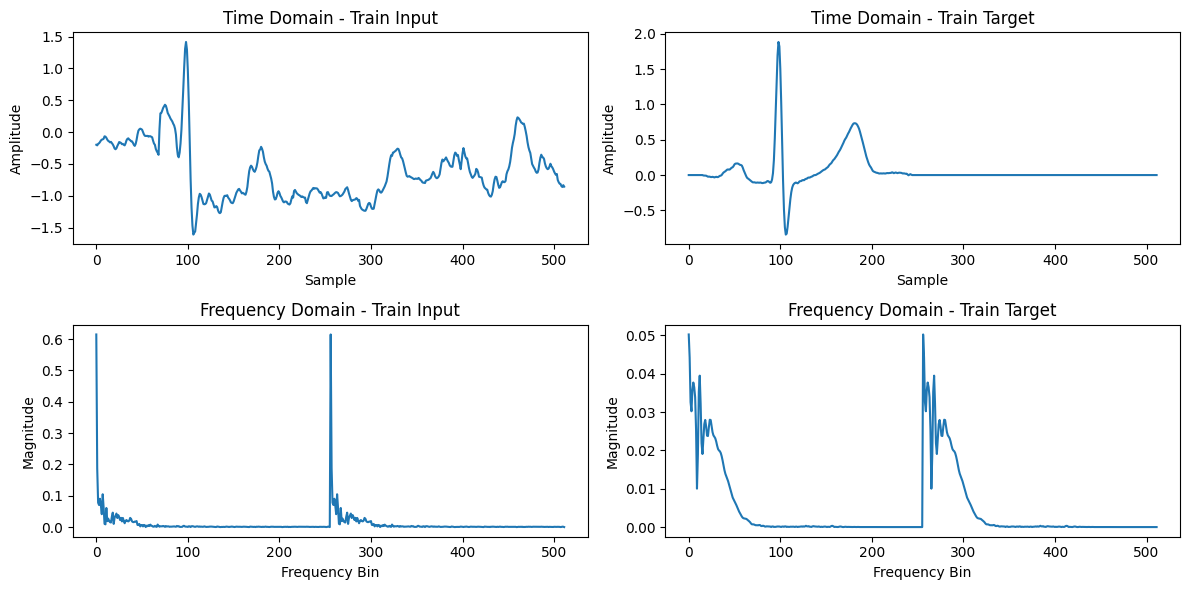

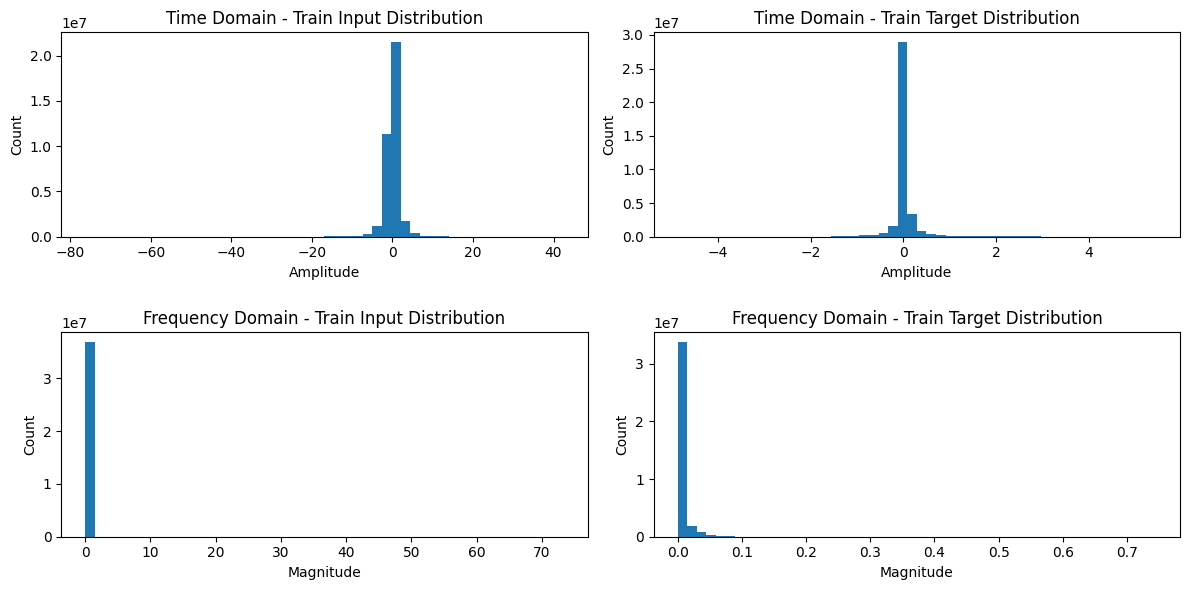

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(X_train[0])
plt.title('Time Domain - Train Input')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(y_train[0])
plt.title('Time Domain - Train Target')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# 주파수 도메인 데이터 시각화
plt.subplot(2, 2, 3)
plt.plot(np.abs(F_train_x[0]))
plt.title('Frequency Domain - Train Input')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')

plt.subplot(2, 2, 4)
plt.plot(np.abs(F_train_y[0]))
plt.title('Frequency Domain - Train Target')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

# 히스토그램을 통한 분포 확인
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(X_train.flatten(), bins=50)
plt.title('Time Domain - Train Input Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
plt.hist(y_train.flatten(), bins=50)
plt.title('Time Domain - Train Target Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
plt.hist(np.abs(F_train_x).flatten(), bins=50)
plt.title('Frequency Domain - Train Input Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
plt.hist(np.abs(F_train_y).flatten(), bins=50)
plt.title('Frequency Domain - Train Target Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [58]:
# 데이터 준비
Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test = Data_Preparation_with_Fourier(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# 모델 초기화 및 가중치 로드
model = Transformer_COMBDAE()
model_filepath = "/home/dhc99/ecg_denoise/1207/Transformer_COMBDAE_weights.best.weights.h5"
model.load_weights(model_filepath)

# 데이터 shape 출력
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"F_train_x shape: {F_train_x.shape}")
print(f"F_train_y shape: {F_train_y.shape}")
print(f"F_test_x shape: {F_test_x.shape}")
print(f"F_test_y shape: {F_test_y.shape}")


Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in train: 7112, total 

In [71]:
np.array(test_IIR).shape
# # np.array(test_Transformer_COMBDAE_FreTS).shape

(3, 13316, 512, 1)

In [74]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def ensure_directory(directory):
    """ 디렉토리가 존재하지 않으면 생성 """
    if not os.path.exists(directory):
        os.makedirs(directory)

def generate_hboxplot(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(15, 6))

    ax = sns.boxplot(data=pd_df, orient="h", width=0.4)  # 가로로 누운 boxplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(ylabel='Models/Methods', xlabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


def generate_violinplots(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set(style="whitegrid")
    ax = sns.violinplot(data=pd_df, palette="Set3", bw=.2, cut=1, linewidth=1, orient="h")  # 가로로 누운 violinplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(xlabel='Models/Methods', ylabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


def generate_barplot(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set(style="whitegrid")
    ax = sns.barplot(data=pd_df, orient="h")  # 가로로 누운 barplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(xlabel='Models/Methods', ylabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


def generate_boxplot(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set(style="whitegrid")
    ax = sns.boxplot(data=pd_df, orient="h")  # 가로로 누운 boxplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(xlabel='Models/Methods', ylabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


# 저장 경로 설정
save_directory = 'plots'

# 파일 이름 설정
filename_ssd_hbox = 'ssd_hboxplot.png'
filename_ssd_violin = 'ssd_violinplot.png'
filename_ssd_bar = 'ssd_barplot.png'
filename_ssd_box = 'ssd_boxplot.png'

filename_mad_hbox = 'mad_hboxplot.png'
filename_mad_violin = 'mad_violinplot.png'
filename_mad_bar = 'mad_barplot.png'
filename_mad_box = 'mad_boxplot.png'

filename_prd_hbox = 'prd_hboxplot.png'
filename_prd_violin = 'prd_violinplot.png'
filename_prd_bar = 'prd_barplot.png'
filename_prd_box = 'prd_boxplot.png'

filename_cos_hbox = 'cos_hboxplot.png'
filename_cos_violin = 'cos_violinplot.png'
filename_cos_bar = 'cos_barplot.png'
filename_cos_box = 'cos_boxplot.png'

# SSD 그래프들 생성
print("Generating SSD plots...")
generate_hboxplot(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_hbox, set_x_axis_size=(0, 100.1))
generate_violinplots(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_violin, set_x_axis_size=(0, 100.1))
generate_barplot(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_bar, set_x_axis_size=(0, 100.1))
generate_boxplot(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_box, set_x_axis_size=(0, 100.1))

# MAD 그래프들 생성
print("Generating MAD plots...")
generate_hboxplot(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_hbox, set_x_axis_size=(0, 3.01))
generate_violinplots(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_violin, set_x_axis_size=(0, 3.01))
generate_barplot(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_bar, set_x_axis_size=(0, 3.01))
generate_boxplot(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_box, set_x_axis_size=(0, 3.01))

# PRD 그래프들 생성
print("Generating PRD plots...")
generate_hboxplot(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_hbox, set_x_axis_size=(0, 150.1))
generate_violinplots(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_violin, set_x_axis_size=(0, 150.1))
generate_barplot(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_bar, set_x_axis_size=(0, 150.1))
generate_boxplot(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_box, set_x_axis_size=(0, 150.1))

# Cosine Similarity 그래프들 생성
print("Generating Cosine Similarity plots...")
generate_hboxplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_hbox, set_x_axis_size=(0, 1))
generate_violinplots(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_violin, set_x_axis_size=(0, 1))
generate_barplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_bar, set_x_axis_size=(0, 1))
generate_boxplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_box, set_x_axis_size=(0, 1))


Generating SSD plots...
Saved: plots/ssd_hboxplot.png
Saved: plots/ssd_violinplot.png
Saved: plots/ssd_barplot.png
Saved: plots/ssd_boxplot.png
Generating MAD plots...
Saved: plots/mad_hboxplot.png
Saved: plots/mad_violinplot.png
Saved: plots/mad_barplot.png
Saved: plots/mad_boxplot.png
Generating PRD plots...
Saved: plots/prd_hboxplot.png
Saved: plots/prd_violinplot.png
Saved: plots/prd_barplot.png
Saved: plots/prd_boxplot.png
Generating Cosine Similarity plots...
Saved: plots/cos_hboxplot.png
Saved: plots/cos_violinplot.png
Saved: plots/cos_barplot.png
Saved: plots/cos_boxplot.png


In [8]:
print("SSD_all:", type(SSD_all), SSD_all.shape if isinstance(SSD_all, np.ndarray) else None)
print("MAD_all:", type(MAD_all), MAD_all.shape if isinstance(MAD_all, np.ndarray) else None)
print("PRD_all:", type(PRD_all), PRD_all.shape if isinstance(PRD_all, np.ndarray) else None)
print("CORR_all:", type(CORR_all), CORR_all.shape if isinstance(CORR_all, np.ndarray) else None)
print("Exp_names:", type(Exp_names), len(Exp_names) if isinstance(Exp_names, list) else None)


SSD_all: <class 'list'> None
MAD_all: <class 'list'> None
PRD_all: <class 'list'> None
CORR_all: <class 'list'> None
Exp_names: <class 'list'> 8


In [79]:
rnd_test = np.load('rnd_test.npy')
# print(rnd_test.shape)
# 13316,
# rnd_test = np.concatenate([rnd_test, rnd_test])
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # real number of segmentations is len(segmentations) - 1
SSD_seg_all = []
MAD_seg_all = []
PRD_seg_all = []
COS_SIM_seg_all = []
SNR_seg_all = []

for idx_exp in range(len(Exp_names)):
    SSD_seg = [[] for _ in range(len(segm) - 1)]
    MAD_seg = [[] for _ in range(len(segm) - 1)]
    PRD_seg = [[] for _ in range(len(segm) - 1)]
    COS_SIM_seg = [[] for _ in range(len(segm) - 1)]
    SNR_seg = [[] for _ in range(len(segm) - 1)]
    for idx_seg in range(len(segm) - 1):
        for idx in range(len(rnd_test)):
            if segm[idx_seg] < rnd_test[idx] < segm[idx_seg + 1]:
                # SSD
                SSD_seg[idx_seg].append(SSD_all[idx_exp][idx])
                # MAD
                MAD_seg[idx_seg].append(MAD_all[idx_exp][idx])
                # PRD
                PRD_seg[idx_seg].append(PRD_all[idx_exp][idx])
                # COS_SIM
                COS_SIM_seg[idx_seg].append(CORR_all[idx_exp][idx])
                # SNR
                SNR_seg[idx_seg].append(SNR_all[idx_exp][idx])
    # 마지막 구간 처리
    SSD_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            SSD_seg[-1].append(SSD_all[idx_exp][idx])
    SSD_seg_all.append(SSD_seg)
    # MAD
    MAD_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            MAD_seg[-1].append(MAD_all[idx_exp][idx])
    MAD_seg_all.append(MAD_seg)
    # PRD
    PRD_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            PRD_seg[-1].append(PRD_all[idx_exp][idx])
    PRD_seg_all.append(PRD_seg)
    # COS SIM
    COS_SIM_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            COS_SIM_seg[-1].append(CORR_all[idx_exp][idx])
    COS_SIM_seg_all.append(COS_SIM_seg)
    # SNR
    SNR_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            SNR_seg[-1].append(SNR_all[idx_exp][idx])
    SNR_seg_all.append(SNR_seg)
    
# Printing Tables
seg_table_column_name = []
for idx_seg in range(len(segm) - 1):
    column_name = str(segm[idx_seg]) + ' < noise < ' + str(segm[idx_seg + 1])
    seg_table_column_name.append(column_name)
# SSD Table
SSD_seg_all = np.array(SSD_seg_all)
SSD_seg_all = np.swapaxes(SSD_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the SSD metric')
generate_table(seg_table_column_name, SSD_seg_all, Exp_names)
# MAD Table
MAD_seg_all = np.array(MAD_seg_all)
MAD_seg_all = np.swapaxes(MAD_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the MAD metric')
generate_table(seg_table_column_name, MAD_seg_all, Exp_names)
# PRD Table
PRD_seg_all = np.array(PRD_seg_all)
PRD_seg_all = np.swapaxes(PRD_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the PRD metric')
generate_table(seg_table_column_name, PRD_seg_all, Exp_names)
# COS SIM Table
COS_SIM_seg_all = np.array(COS_SIM_seg_all)
COS_SIM_seg_all = np.swapaxes(COS_SIM_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the COS SIM metric')
generate_table(seg_table_column_name, COS_SIM_seg_all, Exp_names)
# SNR Table
SNR_seg_all = np.array(SNR_seg_all)
SNR_seg_all = np.swapaxes(SNR_seg_all, 0, 1)

print('\n')
print('Printing Table for different noise values on the SNR metric')
generate_table(seg_table_column_name, SNR_seg_all, Exp_names)
# print(SNR_seg_all)
# 저장 경로 설정

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (8, 4) + inhomogeneous part.

In [80]:
for idx, seg in enumerate(SSD_seg_all):
    print(f"Index {idx}: Length: {len(seg)}, Sub-segment lengths: {[len(subseg) for subseg in seg]}")


Index 0: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]
Index 1: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]
Index 2: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]
Index 3: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]
Index 4: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]
Index 5: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]
Index 6: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]
Index 7: Length: 4, Sub-segment lengths: [2858, 2859, 3679, 3615]


## sample 로 잘라서 해보기

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def visualize_signals(qtdb_path='data/QTDatabase.pkl', 
                      combined_noise_path='data/CombinedNoise.pkl',
                      transformer_combdae_path='1208/test_results_Transformer_COMBDAE.pkl',
                      output_dir='viz1208'):
    
    # 데이터 로드
    with open(qtdb_path, 'rb') as f:
        qtdb = pickle.load(f)
    
    with open(combined_noise_path, 'rb') as f:
        combined_noise = pickle.load(f)
    
    with open(transformer_combdae_path, 'rb') as f:
        filtered_data = pickle.load(f)
    
    X_test, y_test, y_pred = filtered_data

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 샘플링 주파수와 세그먼트 길이 설정
    fs = 360
    segment_length = 15 * fs

    for signal_name, beats in qtdb.items():
        # 전체 신호 생성 (15초)
        original_signal = np.concatenate(beats)[:segment_length]

        # 노이즈 추가
        rnd_scale = np.random.randint(low=20, high=200) / 100
        noise = combined_noise[0][:, 0]  # 첫 번째 채널, 0 번째 노이즈 조합 선택
        noise_segment = noise[:segment_length]
        
        beat_max_value = np.max(original_signal) - np.min(original_signal)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_scale / Ase
        noisy_signal = original_signal + alpha * noise_segment

        # noisy_signal을 X_test와 같은 길이(512)로 자르기
        noisy_signal = noisy_signal[:512]
        
        # 필터링된 신호 찾기 (가장 유사한 신호 선택)
        noisy_signal_reshaped = noisy_signal.reshape(1, -1, 1)
        diff = np.sum((X_test - noisy_signal_reshaped)**2, axis=(1, 2))
        closest_idx = np.argmin(diff)
        filtered_signal = y_pred[closest_idx].flatten()

        # 시간 축 생성
        time = np.arange(segment_length) / fs

        # Figure 1: 원본 신호와 노이즈가 추가된 신호
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 1, 1)
        plt.plot(time, original_signal, linewidth=0.5)
        plt.title(f'{signal_name} - Original Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(2, 1, 2)
        plt.plot(time[:512], noisy_signal, linewidth=0.5)
        plt.title(f'{signal_name} - Noisy Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.tight_layout()
        plt.savefig(f'{output_dir}/{signal_name}_original_vs_noisy.png', dpi=300)
        plt.close()

        # Figure 2: 원본 신호와 필터링된 신호
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 1, 1)
        plt.plot(time[:512], original_signal[:512], linewidth=0.5)
        plt.title(f'{signal_name} - Original Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(2, 1, 2)
        plt.plot(time[:512], filtered_signal, linewidth=0.5)
        plt.title(f'{signal_name} - Filtered Signal (Transformer_COMBDAE)')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.tight_layout()
        plt.savefig(f'{output_dir}/{signal_name}_original_vs_filtered.png', dpi=300)
        plt.close()

        print(f"Visualized signals for {signal_name}")

# 시각화 실행
visualize_signals()

Visualized signals for sele0122
Visualized signals for sele0107
Visualized signals for sel16272
Visualized signals for sele0604
Visualized signals for sel104
Visualized signals for sel232
Visualized signals for sel16539
Visualized signals for sel33
Visualized signals for sele0606
Visualized signals for sel32
Visualized signals for sel871
Visualized signals for sel39
Visualized signals for sele0110
Visualized signals for sele0126
Visualized signals for sel302
Visualized signals for sele0129
Visualized signals for sel14172
Visualized signals for sele0114
Visualized signals for sel883
Visualized signals for sel48
Visualized signals for sele0104
Visualized signals for sele0509
Visualized signals for sele0603
Visualized signals for sel38
Visualized signals for sel230
Visualized signals for sel14157
Visualized signals for sel16773
Visualized signals for sel114
Visualized signals for sel233
Visualized signals for sel52
Visualized signals for sel35
Visualized signals for sele0136
Visualized si

sel16786_noise_6_segment_103.pkl
sel16786_noise_6_segment_208.pkl
sel16786_noise_6_segment_313.pkl
sel16786_noise_6_segment_418.pkl
sel16786_noise_6_segment_523.pkl
sel16786_noise_6_segment_628.pkl
sel16786_noise_6_segment_733.pkl
sel16786_noise_6_segment_838.pkl
sel16786_noise_6_segment_943.pkl
sel16786_noise_6_segment_1048.pkl
sel16786_noise_6_segment_1153.pkl
sel16786_noise_6_segment_1258.pkl
sel16786_noise_6_segment_1363.pkl
sel16786_noise_6_segment_1468.pkl
sel16786_noise_6_segment_1573.pkl
sel16786_noise_6_segment_1678.pkl
sel16786_noise_6_segment_1783.pkl
sel16786_noise_6_segment_1888.pkl
sel16786_noise_6_segment_1993.pkl
sel16786_noise_6_segment_2098.pkl
sel16786_noise_6_segment_2203.pkl
sel16786_noise_6_segment_2308.pkl
sel16786_noise_6_segment_2413.pkl
sel16786_noise_6_segment_2518.pkl
sel16786_noise_6_segment_2623.pkl
sel16786_noise_6_segment_2728.pkl
sel16786_noise_6_segment_2833.pkl
sel16786_noise_6_segment_2938.pkl
sel16786_noise_6_segment_3043.pkl
sel16786_noise_6_segmen

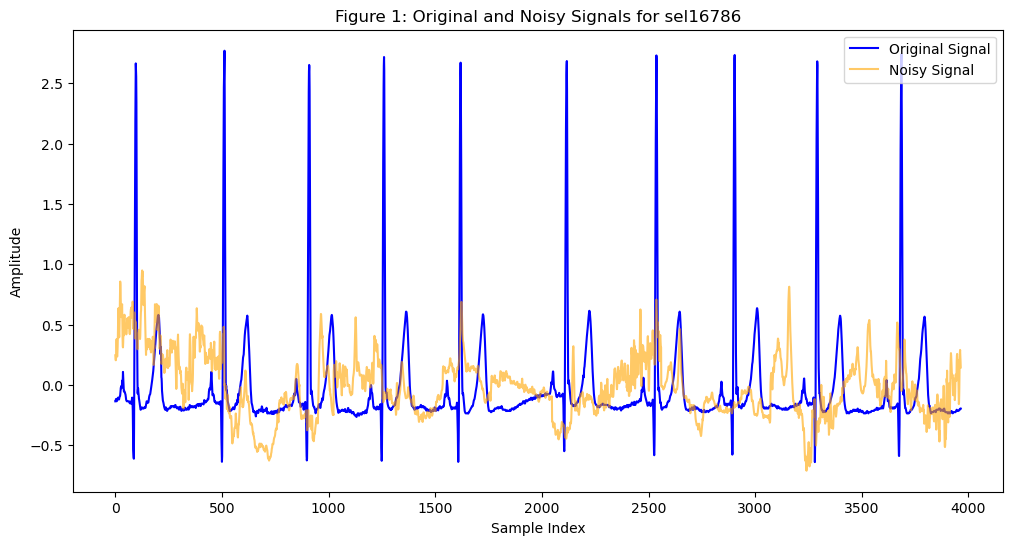

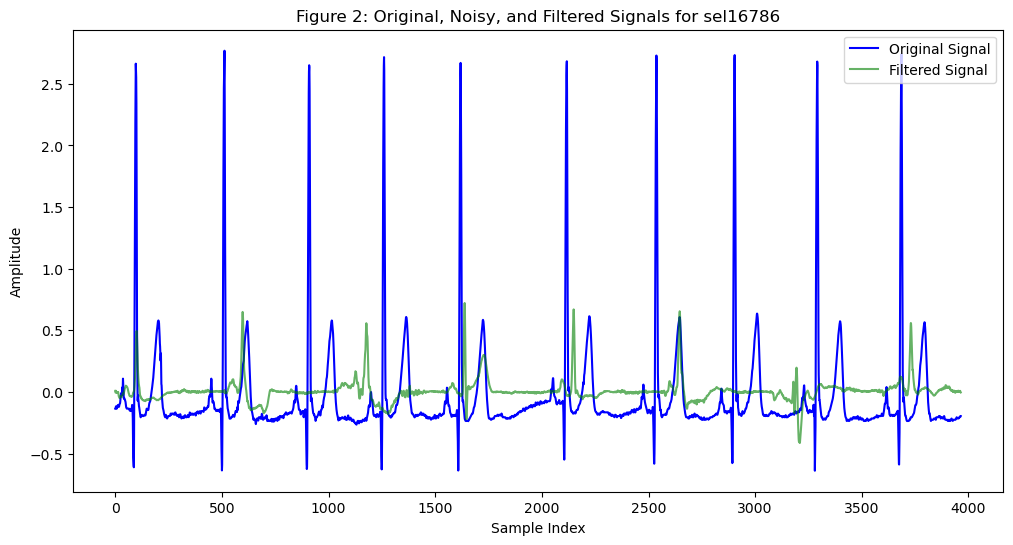

In [110]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the Transformer_COMBDAE filtered results
with open('1030/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    test_results_combdae = pickle.load(input)

# Define a function to load all noisy segments for a given signal name from a directory
def load_noisy_segments(signal_name, segment_dir='data/noisy_segments/test'):
    noisy_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            noisy_segment = pickle.load(segment_file)
            print(filename)
            noisy_segments.append(noisy_segment)
    return noisy_segments

# Define a function to load all original segments for a given signal name from a directory
def load_original_segments(signal_name, segment_dir='data/original_segments'):
    original_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            # print(filename)
            original_segment = pickle.load(segment_file)
            original_segments.append(original_segment)
    return original_segments

# Load the noisy and original segments
signal_name = 'sel16786'
original_segments = load_original_segments(signal_name, 'data/original_segments')
noisy_segments = load_noisy_segments(signal_name, 'data/noisy_segments/test')
_, _, filtered_segments = test_results_combdae  # Assuming this is the format [X_test, y_test, y_pred]

# Ensure the number of segments match between original, noisy, and filtered data
min_segments = min(len(original_segments), len(noisy_segments), len(filtered_segments))
original_segments = original_segments[:min_segments]
noisy_segments = noisy_segments[:min_segments]
filtered_segments = filtered_segments[:min_segments]

# Concatenate the first 5 segments into a continuous signal for each type
num_segments_to_display = 10
concatenated_original = np.concatenate(original_segments[:num_segments_to_display])
concatenated_noisy = np.concatenate(noisy_segments[:num_segments_to_display])
concatenated_filtered = np.concatenate(filtered_segments[:num_segments_to_display])

# Truncate all concatenated signals to the length of the shortest one
min_length = min(len(concatenated_original), len(concatenated_noisy), len(concatenated_filtered))
concatenated_original = concatenated_original[:min_length]
concatenated_noisy = concatenated_noisy[:min_length]
concatenated_filtered = concatenated_filtered[:min_length]

# Define the x-axis for plotting
x_axis = np.arange(min_length)

# Plot Figure 1: Original vs Noisy Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_noisy, label='Noisy Signal', color='orange', alpha=0.6)
plt.title(f'Figure 1: Original and Noisy Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot Figure 2: Original, Noisy, and Filtered Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_filtered, label='Filtered Signal', color='green', alpha=0.6)
plt.title(f'Figure 2: Original, Noisy, and Filtered Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


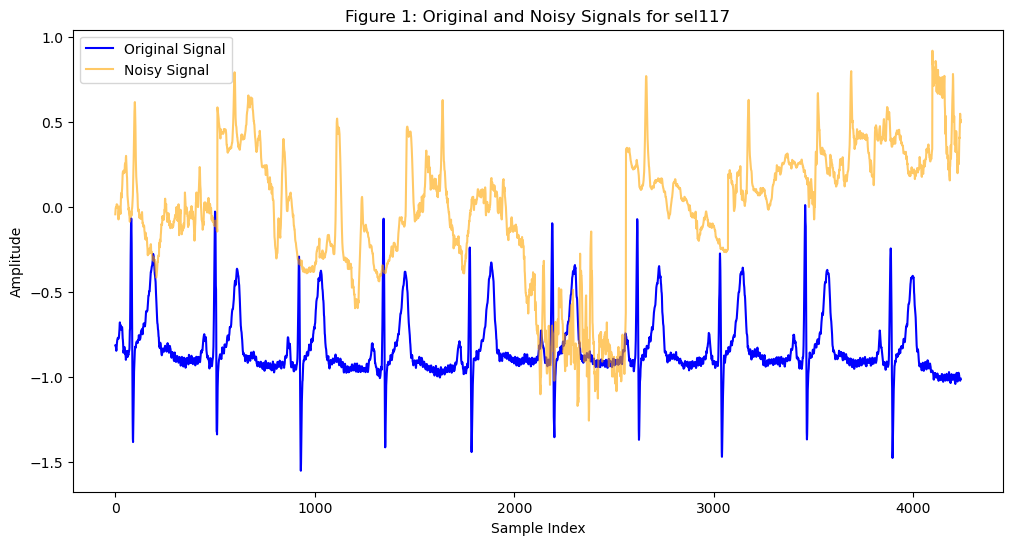

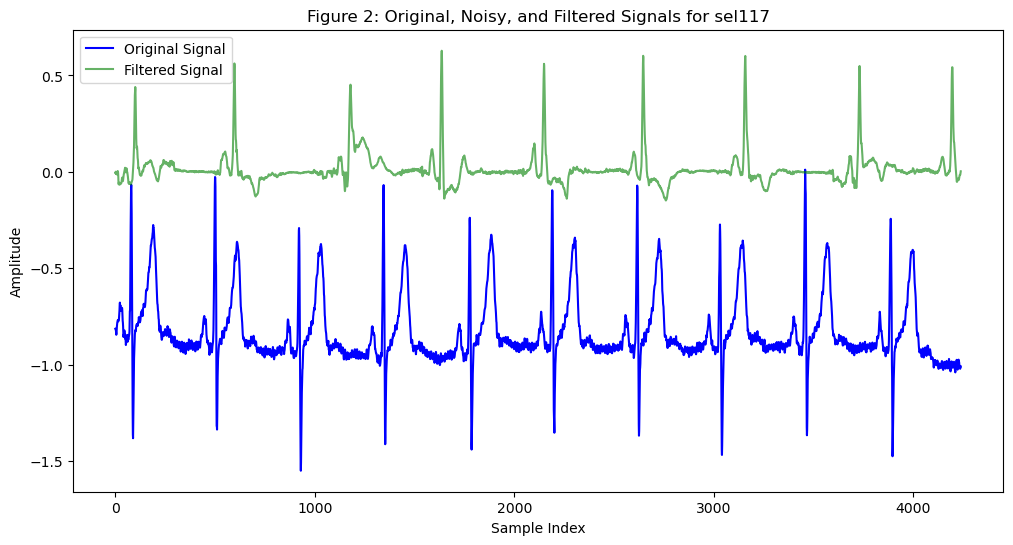

In [99]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the Transformer_COMBDAE filtered results
with open('1031_trainbwtestbw/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    test_results_combdae = pickle.load(input)

# Define a function to load all noisy segments for a given signal name from a directory
def load_noisy_segments(signal_name, segment_dir='data/noisy_segments/test'):
    noisy_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            noisy_segment = pickle.load(segment_file)
            noisy_segments.append(noisy_segment)
    return noisy_segments

# Define a function to load all original segments for a given signal name from a directory
def load_original_segments(signal_name, segment_dir='data/original_segments'):
    original_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            original_segment = pickle.load(segment_file)
            original_segments.append(original_segment)
    return original_segments

# Load the noisy and original segments
signal_name = 'sel117'
original_segments = load_original_segments(signal_name, 'data/original_segments')
noisy_segments = load_noisy_segments(signal_name, 'data/noisy_segments/test')
_, _, filtered_segments = test_results_combdae  # Assuming this is the format [X_test, y_test, y_pred]

# Ensure the number of segments match between original, noisy, and filtered data
min_segments = min(len(original_segments), len(noisy_segments), len(filtered_segments))
original_segments = original_segments[:min_segments]
noisy_segments = noisy_segments[:min_segments]
filtered_segments = filtered_segments[:min_segments]

# Concatenate the first 5 segments into a continuous signal for each type
num_segments_to_display = 10
concatenated_original = np.concatenate(original_segments[:num_segments_to_display])
concatenated_noisy = np.concatenate(noisy_segments[:num_segments_to_display])
concatenated_filtered = np.concatenate(filtered_segments[:num_segments_to_display])

# Truncate all concatenated signals to the length of the shortest one
min_length = min(len(concatenated_original), len(concatenated_noisy), len(concatenated_filtered))
concatenated_original = concatenated_original[:min_length]
concatenated_noisy = concatenated_noisy[:min_length]
concatenated_filtered = concatenated_filtered[:min_length]

# Define the x-axis for plotting
x_axis = np.arange(min_length)

# Plot Figure 1: Original vs Noisy Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_noisy, label='Noisy Signal', color='orange', alpha=0.6)
plt.title(f'Figure 1: Original and Noisy Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot Figure 2: Original, Noisy, and Filtered Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_filtered, label='Filtered Signal', color='green', alpha=0.6)
plt.title(f'Figure 2: Original, Noisy, and Filtered Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [117]:
import os
import glob

# Define paths
test_path = '/home/dhc99/ecg_denoise/data/noisy_segments/test'
train_path = '/home/dhc99/ecg_denoise/data/noisy_segments/train'

# Count pkl files in test directory
test_pkls = glob.glob(os.path.join(test_path, '*.pkl'))
test_count = len(test_pkls)

# Count pkl files in train directory
train_pkls = glob.glob(os.path.join(train_path, '*.pkl'))
train_count = len(train_pkls)

print(f"테스트 폴더의 pkl 파일 개수: {test_count}")
print(f"학습 폴더의 pkl 파일 개수: {train_count}")

테스트 폴더의 pkl 파일 개수: 13316
학습 폴더의 pkl 파일 개수: 72002


In [121]:
import os
import glob

# 경로 정의
test_path = '/home/dhc99/ecg_denoise/data/noisy_segments/test'
train_path = '/home/dhc99/ecg_denoise/data/noisy_segments/train'

# test 폴더에서 13316.pkl로 끝나는 파일 찾기
test_files = glob.glob(os.path.join(test_path, '*13315.pkl'))
print("\n테스트 폴더에서 찾은 파일들:")
for file in test_files:
    print(f"- {os.path.basename(file)}")

# train 폴더에서 13316.pkl로 끝나는 파일 찾기
train_files = glob.glob(os.path.join(train_path, '*13315.pkl'))
print("\n학습 폴더에서 찾은 파일들:")
for file in train_files:
    print(f"- {os.path.basename(file)}")

print(f"\n총 찾은 파일 개수: test={len(test_files)}, train={len(train_files)}")


테스트 폴더에서 찾은 파일들:
- sel41_noise_2_segment_13315.pkl

학습 폴더에서 찾은 파일들:
- sel41_noise_2_segment_13315.pkl

총 찾은 파일 개수: test=1, train=1


모델별 시각화한거 *

In [9]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def ecg_view_comparison(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                        noise_indices=None, signal_name=None, save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate segments for plotting
    ecg_concat = np.concatenate(ecg_segments[:num_segments])
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])
    ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

    # Plot comparison
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(ecg_blw_concat, 'r--', alpha=0.6, label='Noisy ECG (Input)')
    ax.plot(ecg_concat, 'g-', label='Original ECG (Ground Truth)', lw=2)
    ax.plot(ecg_dl_concat, 'b-.', label=f'{model_name} Filtered ECG', lw=2.5)

    # Highlight noise effect reduction
    noise_diff = ecg_blw_concat - ecg_dl_concat
    ax.plot(noise_diff, 'm:', alpha=0.7, label='Noise Reduction (Difference)', lw=1.5)

    # Grid, labels, and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('Amplitude (au)')
    ax.set_xlabel('Sample Index')
    # Set title with bold and large font
    ax.set_title(f"Signal Comparison for {model_name}", fontsize=20, fontweight='bold')
    ax.legend(loc='upper right', fontsize=12)

    # Save the figure
    filename = f"Comparison_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.close(fig)  # Close figure to free memory
    print(f"Saved: {filepath}")


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'Multibranch LANLD', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']

model_results = {}
for model_name in dl_experiments:
    file_path = f"1208/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1208/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1208/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 4
signals_index = [1033, 1034, 1035, 1036]  # Indices of segments to plot
noise_indices = [i for i in signals_index]  # Example noise indices

# Loop through each model and generate plots
for model_name, (X_test, y_test, y_pred) in model_results.items():
    # Prepare segments for plotting
    ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
    ecg_signals2plot = [y_test[i] for i in signals_index]  # Original segments
    dl_signals2plot = [y_pred[i] for i in signals_index]  # Model-filtered segments

    # Generate comparison plot for the model
    ecg_view_comparison(ecg_segments=ecg_signals2plot,
                        ecg_blw_segments=ecgbl_signals2plot,
                        ecg_dl_segments=dl_signals2plot,
                        model_name=model_name,
                        noise_indices=noise_indices,
                        signal_name=signal_name,
                        save_dir='view_comparison',
                        num_segments=segments_to_plot)


Saved: view_comparison/Comparison_Example_Signal_DRNN_Segments_4.png
Saved: view_comparison/Comparison_Example_Signal_FCN-DAE_Segments_4.png
Saved: view_comparison/Comparison_Example_Signal_Multibranch LANLD_Segments_4.png
Saved: view_comparison/Comparison_Example_Signal_AttentionSkipDAE_Segments_4.png
Saved: view_comparison/Comparison_Example_Signal_Transformer_DAE_Segments_4.png
Saved: view_comparison/Comparison_Example_Signal_Transformer_COMBDAE_Segments_4.png
Saved: view_comparison/Comparison_Example_Signal_FIR_Filter_Segments_4.png
Saved: view_comparison/Comparison_Example_Signal_IIR_Filter_Segments_4.png


## 진짜 시각화


0.2 ~ 2.0 구간별로 하고싶었다.


In [ ]:
# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt

# # Noise levels for testing
# segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# # Ensure directory for saving images exists
# def ensure_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # Function to plot concatenated ECG segments with noise information and metrics
# def plot_concatenated_ecg_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
#     """
#     Generates a single plot of concatenated Original, Noisy, and Filtered ECG signals for a given noise range.
#     """
#     # Concatenate all segments
#     ecg_concat_original = np.concatenate(ecg_original)
#     ecg_concat_noisy = np.concatenate(ecg_noisy)
#     ecg_concat_filtered = np.concatenate(ecg_filtered)

#     # Create a figure
#     plt.figure(figsize=(14, 6))

#     # Plot Original, Noisy, and Filtered signals
#     plt.plot(ecg_concat_original, label='Original', color='red', linewidth=1.5)
#     plt.plot(ecg_concat_noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0, alpha=0.8)
#     plt.plot(ecg_concat_filtered, label='Filtered', color='green', linewidth=1.2, alpha=0.85)

#     # Add metrics as text
#     metrics_text = (
#         f"SSD: {np.mean(metrics['SSD']):.2f}, "
#         f"MAD: {np.mean(metrics['MAD']):.3f}, "
#         f"PRD: {np.mean(metrics['PRD']):.2f}, "
#         f"Cosine Sim: {np.mean(metrics['COS_SIM']):.3f}"
#     )
#     plt.title(f"Noise Range: {noise_range}\nMetrics: {metrics_text}", fontsize=24, fontweight='bold')
#     plt.xlabel("Sample Index", fontsize=14)
#     plt.ylabel("Amplitude (a.u.)", fontsize=14)

#     plt.legend(loc="upper right", fontsize=12)
#     plt.grid(True, linestyle=':', alpha=0.7)

#     # Save the image
#     plt.tight_layout()
#     plt.savefig(save_path, dpi=300)
#     plt.close()
#     print(f"Saved plot: {save_path}")

# # Load Transformer_COMBDAE results
# with open("1208/test_results_Transformer_COMBDAE.pkl", "rb") as input_file:
#     X_test, y_test, y_pred = pickle.load(input_file)

# # Load rnd_test (noise levels)
# rnd_test = np.load("rnd_test.npy")

# def calculate_metrics(y_original, y_filtered):
#     """
#     Calculate evaluation metrics for the filtered signal compared to the original signal.

#     Parameters:
#         y_original (ndarray): Original signal.
#         y_filtered (ndarray): Filtered signal.

#     Returns:
#         dict: Dictionary containing SSD, MAD, PRD, and Cosine Similarity metrics.
#     """
#     # Flatten the signals to ensure 1D for metric calculations
#     y_original = y_original.flatten()
#     y_filtered = y_filtered.flatten()

#     # SSD
#     ssd = np.sum((y_original - y_filtered) ** 2)

#     # MAD
#     mad = np.mean(np.abs(y_original - y_filtered))

#     # PRD
#     prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

#     # Cosine Similarity
#     cosine_sim = np.dot(y_original, y_filtered) / (
#         np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
#     )

#     return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim}


# # Loop through each noise segment range and each noise level
# for i in range(len(segm) - 1):
#     noise_start, noise_end = segm[i], segm[i + 1]
#     noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0][:7]  # Limit to 7 segments

#     if len(noise_indices) == 0:
#         print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
#         continue

#     # Prepare metrics for this range
#     metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": []}

#     # Compute metrics for selected samples
#     for idx in noise_indices:
#         metrics = calculate_metrics(y_original=y_test[idx], y_filtered=y_pred[idx])
#         for key, value in metrics.items():
#             metrics_range[key].append(value)

#     # Prepare data for plotting
#     ecg_original = [y_test[idx].flatten() for idx in noise_indices]
#     ecg_noisy = [X_test[idx].flatten() for idx in noise_indices]
#     ecg_filtered = [y_pred[idx].flatten() for idx in noise_indices]

#     # Save path for the plot
#     save_dir = "view_comp_concat_plots"
#     ensure_directory(save_dir)
#     save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_concat_comparison.png")

#     # Plot and save
#     plot_concatenated_ecg_with_metrics(
#         ecg_original, ecg_noisy, ecg_filtered, metrics_range,
#         noise_range=f"{noise_start} < noise < {noise_end}",
#         save_path=save_path
#     )


Saved plot: view_comp_concat_plots/Noise_0.2_0.6_concat_comparison.png
Saved plot: view_comp_concat_plots/Noise_0.6_1.0_concat_comparison.png
Saved plot: view_comp_concat_plots/Noise_1.0_1.5_concat_comparison.png
Saved plot: view_comp_concat_plots/Noise_1.5_2.0_concat_comparison.png


combdae로 구간별 비교

In [20]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information and metrics
def plot_concatenated_ecg_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
    """
    Generates a single plot of concatenated Original, Noisy, and Filtered ECG signals for a given noise range.
    """
    # Concatenate all segments
    ecg_concat_original = np.concatenate(ecg_original)
    ecg_concat_noisy = np.concatenate(ecg_noisy)
    ecg_concat_filtered = np.concatenate(ecg_filtered)

    # Create a figure
    plt.figure(figsize=(14, 6))

    # Plot Original, Noisy, and Filtered signals
    plt.plot(ecg_concat_original, label='Original', color='red', linewidth=1.5)
    plt.plot(ecg_concat_noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0, alpha=0.8)
    plt.plot(ecg_concat_filtered, label='Filtered', color='green', linewidth=1.2, alpha=0.85)

    # Add metrics as text
    metrics_text = (
        f"SSD: {np.mean(metrics['SSD']):.2f}, "
        f"MAD: {np.mean(metrics['MAD']):.3f}, "
        f"PRD: {np.mean(metrics['PRD']):.2f}, "
        f"Cosine Sim: {np.mean(metrics['COS_SIM']):.3f}"
    )
    plt.title(f"Noise Range: {noise_range}\nMetrics: {metrics_text}", fontsize=24, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=14)
    plt.ylabel("Amplitude (a.u.)", fontsize=14)

    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)

    # Save the image
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved plot: {save_path}")

# Load Transformer_COMBDAE results
with open("1208/test_results_Transformer_COMBDAE.pkl", "rb") as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")

def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, and Cosine Similarity metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD
    mad = np.mean(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim}


# Loop through each noise segment range and each noise level
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    # Prepare metrics for this range
    metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": []}

    # Compute metrics for all samples in the range
    for idx in noise_indices:
        metrics = calculate_metrics(y_original=y_test[idx], y_filtered=y_pred[idx])
        for key, value in metrics.items():
            metrics_range[key].append(value)

    # Select up to 7 samples for visualization
    vis_indices = noise_indices[107:114]
    ecg_original = [y_test[idx].flatten() for idx in vis_indices]
    ecg_noisy = [X_test[idx].flatten() for idx in vis_indices]
    ecg_filtered = [y_pred[idx].flatten() for idx in vis_indices]

    # Save path for the plot
    save_dir = "view_comp_concat_plots"
    ensure_directory(save_dir)
    save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_concat_comparison.png")

    # Plot and save
    plot_concatenated_ecg_with_metrics(
        ecg_original, ecg_noisy, ecg_filtered, metrics_range,
        noise_range=f"{noise_start} < noise < {noise_end}",
        save_path=save_path
    )

    # Print metrics summary for this range
    print(f"Metrics for Noise Range {noise_start} to {noise_end}:")
    for key in metrics_range.keys():
        print(f"  {key}: Mean = {np.mean(metrics_range[key]):.4f}, Std = {np.std(metrics_range[key]):.4f}")


Saved plot: view_comp_concat_plots/Noise_0.2_0.6_concat_comparison.png
Metrics for Noise Range 0.2 to 0.6:
  SSD: Mean = 3.5897, Std = 5.6235
  MAD: Mean = 0.0409, Std = 0.0261
  PRD: Mean = 32.8091, Std = 14.1779
  COS_SIM: Mean = 0.9407, Std = 0.0581
Saved plot: view_comp_concat_plots/Noise_0.6_1.0_concat_comparison.png
Metrics for Noise Range 0.6 to 1.0:
  SSD: Mean = 4.2850, Std = 6.7194
  MAD: Mean = 0.0446, Std = 0.0257
  PRD: Mean = 37.6232, Std = 15.5198
  COS_SIM: Mean = 0.9214, Std = 0.0746
Saved plot: view_comp_concat_plots/Noise_1.0_1.5_concat_comparison.png
Metrics for Noise Range 1.0 to 1.5:
  SSD: Mean = 5.1525, Std = 8.2639
  MAD: Mean = 0.0486, Std = 0.0287
  PRD: Mean = 41.1454, Std = 17.4425
  COS_SIM: Mean = 0.9028, Std = 0.0988
Saved plot: view_comp_concat_plots/Noise_1.5_2.0_concat_comparison.png
Metrics for Noise Range 1.5 to 2.0:
  SSD: Mean = 6.7450, Std = 9.1653
  MAD: Mean = 0.0551, Std = 0.0312
  PRD: Mean = 46.8676, Std = 19.8337
  COS_SIM: Mean = 0.8735, S

DAE로 구간별 비교

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information and metrics
def plot_concatenated_ecg_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
    """
    Generates a single plot of concatenated Original, Noisy, and Filtered ECG signals for a given noise range.
    """
    # Concatenate all segments
    ecg_concat_original = np.concatenate(ecg_original)
    ecg_concat_noisy = np.concatenate(ecg_noisy)
    ecg_concat_filtered = np.concatenate(ecg_filtered)

    # Create a figure
    plt.figure(figsize=(14, 6))

    # Plot Original, Noisy, and Filtered signals
    plt.plot(ecg_concat_original, label='Original', color='red', linewidth=1.5)
    plt.plot(ecg_concat_noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0, alpha=0.8)
    plt.plot(ecg_concat_filtered, label='Filtered', color='green', linewidth=1.2, alpha=0.85)

    # Add metrics as text
    metrics_text = (
        f"SSD: {np.mean(metrics['SSD']):.2f}, "
        f"MAD: {np.mean(metrics['MAD']):.3f}, "
        f"PRD: {np.mean(metrics['PRD']):.2f}, "
        f"Cosine Sim: {np.mean(metrics['COS_SIM']):.3f}"
    )
    plt.title(f"Noise Range: {noise_range}\nMetrics: {metrics_text}", fontsize=24, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=14)
    plt.ylabel("Amplitude (a.u.)", fontsize=14)

    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)

    # Save the image
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved plot: {save_path}")

# Load Transformer_COMBDAE results
with open("1208/test_results_Transformer_DAE.pkl", "rb") as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")

def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, and Cosine Similarity metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD
    mad = np.mean(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim}


# Loop through each noise segment range and each noise level
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    # Prepare metrics for this range
    metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": []}

    # Compute metrics for all samples in the range
    for idx in noise_indices:
        metrics = calculate_metrics(y_original=y_test[idx], y_filtered=y_pred[idx])
        for key, value in metrics.items():
            metrics_range[key].append(value)

    # Select up to 7 samples for visualization
    vis_indices = noise_indices[107:114]
    ecg_original = [y_test[idx].flatten() for idx in vis_indices]
    ecg_noisy = [X_test[idx].flatten() for idx in vis_indices]
    ecg_filtered = [y_pred[idx].flatten() for idx in vis_indices]

    # Save path for the plot
    save_dir = "view_comp_concat_plots2"
    ensure_directory(save_dir)
    save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_concat_comparison.png")

    # Plot and save
    plot_concatenated_ecg_with_metrics(
        ecg_original, ecg_noisy, ecg_filtered, metrics_range,
        noise_range=f"{noise_start} < noise < {noise_end}",
        save_path=save_path
    )

    # Print metrics summary for this range
    print(f"Metrics for Noise Range {noise_start} to {noise_end}:")
    for key in metrics_range.keys():
        print(f"  {key}: Mean = {np.mean(metrics_range[key]):.4f}, Std = {np.std(metrics_range[key]):.4f}")


Saved plot: view_comp_concat_plots2/Noise_0.2_0.6_concat_comparison.png
Metrics for Noise Range 0.2 to 0.6:
  SSD: Mean = 3.9106, Std = 6.0080
  MAD: Mean = 0.0431, Std = 0.0269
  PRD: Mean = 34.8405, Std = 14.8994
  COS_SIM: Mean = 0.9316, Std = 0.0635
Saved plot: view_comp_concat_plots2/Noise_0.6_1.0_concat_comparison.png
Metrics for Noise Range 0.6 to 1.0:
  SSD: Mean = 4.7409, Std = 7.2606
  MAD: Mean = 0.0467, Std = 0.0276
  PRD: Mean = 39.1913, Std = 16.3123
  COS_SIM: Mean = 0.9122, Std = 0.0854
Saved plot: view_comp_concat_plots2/Noise_1.0_1.5_concat_comparison.png
Metrics for Noise Range 1.0 to 1.5:
  SSD: Mean = 5.9216, Std = 9.2989
  MAD: Mean = 0.0516, Std = 0.0310
  PRD: Mean = 43.8354, Std = 19.2194
  COS_SIM: Mean = 0.8871, Std = 0.1185
Saved plot: view_comp_concat_plots2/Noise_1.5_2.0_concat_comparison.png
Metrics for Noise Range 1.5 to 2.0:
  SSD: Mean = 7.4291, Std = 9.8291
  MAD: Mean = 0.0577, Std = 0.0328
  PRD: Mean = 49.1602, Std = 20.5375
  COS_SIM: Mean = 0.858

In [ ]:
import seaborn as sns

def plot_metrics_heatmap(model_results, noise_indices, metrics=["PRD", "SSD", "MAD"], save_path="metrics_heatmap.png"):
    """
    Generate a heatmap of metrics across models.
    """
    metric_values = {metric: [] for metric in metrics}
    model_names = []

    for model_name, (_, y_test, y_pred) in model_results.items():
        model_names.append(model_name)
        for metric in metrics:
            values = [calculate_metrics(y_test[idx], y_pred[idx])[metric] for idx in noise_indices]
            metric_values[metric].append(np.mean(values))
    
    # Convert to DataFrame
    heatmap_data = pd.DataFrame(metric_values, index=model_names)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Model Performance Heatmap", fontsize=20, fontweight="bold")
    plt.xlabel("Metric", fontsize=14)
    plt.ylabel("Model", fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved heatmap: {save_path}")


Saved plot: difference_plots_per_noise/Noise_0.2_0.6_model_differences.png
Saved plot: difference_plots_per_noise/Noise_0.6_1.0_model_differences.png
Saved plot: difference_plots_per_noise/Noise_1.0_1.5_model_differences.png
Saved plot: difference_plots_per_noise/Noise_1.5_2.0_model_differences.png


In [11]:
def plot_model_differences_individual(model_results, vis_indices, noise_range, save_dir):
    """
    Plot differences for each model in individual plots.
    """
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        differences = [y_test[idx].flatten() - y_pred[idx].flatten() for idx in vis_indices]
        concatenated_diff = np.concatenate(differences)

        plt.figure(figsize=(14, 6))
        plt.plot(concatenated_diff, label=f'{model_name} Difference', color='blue', linewidth=1.5)

        plt.title(f"Difference Signal: {model_name}\nNoise Range: {noise_range}", fontsize=20, fontweight='bold')
        plt.xlabel("Sample Index", fontsize=14)
        plt.ylabel("Difference Amplitude (a.u.)", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()

        # Save individual plot
        save_path = os.path.join(save_dir, f"{model_name}_Noise_{noise_range.replace('<', '_')}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Saved individual plot for {model_name}: {save_path}")

# Noise range 처리 및 저장 경로 설정
save_dir_individual = "difference_plots_individual"
ensure_directory(save_dir_individual)

for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    vis_indices = noise_indices[:7]  # 최대 7개 샘플 선택
    noise_range_str = f"{noise_start} < noise < {noise_end}"

    plot_model_differences_individual(
        model_results, vis_indices, noise_range_str, save_dir_individual
    )


Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FCN-DAE: difference_plots_individual/FCN-DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Multibranch LANLD: difference_plots_individual/Multibranch LANLD_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for AttentionSkipDAE: difference_plots_individual/AttentionSkipDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_DAE: difference_plots_individual/Transformer_DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_COMBDAE: difference_plots_individual/Transformer_COMBDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FIR_Filter: difference_plots_individual/FIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for IIR_Filter: difference_plots_individual/IIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.6 _ noise _ 1.0.png
Saved individual plot for FCN-D

In [12]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Calculate metrics for a given model
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.
    """
    # Flatten signals for calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD
    mad = np.mean(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim}

# Generate a heatmap from metrics
def generate_metrics_heatmap(model_results, noise_indices, metrics=["PRD", "SSD", "MAD", "COS_SIM"], save_path="metrics_heatmap.png"):
    """
    Generate a heatmap summarizing model performance across metrics.
    """
    metric_values = {metric: [] for metric in metrics}
    model_names = []

    # Calculate metrics for each model
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        model_names.append(model_name)
        for metric in metrics:
            values = [calculate_metrics(y_test[idx], y_pred[idx])[metric] for idx in noise_indices]
            metric_values[metric].append(np.mean(values))  # Store mean of the metric

    # Convert to DataFrame
    heatmap_data = pd.DataFrame(metric_values, index=model_names)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Model Performance Heatmap", fontsize=20, fontweight="bold")
    plt.xlabel("Metric", fontsize=14)
    plt.ylabel("Model", fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved heatmap: {save_path}")

# Load results from models
dl_experiments = ['DRNN', 'FCN-DAE', 'Multibranch LANLD', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']
model_results = {}

# Load model results
for model_name in dl_experiments:
    file_path = f"1208/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1208/test_results_FIR.pkl', 'rb') as input_file:
    model_results["FIR_Filter"] = pickle.load(input_file)

with open('1208/test_results_IIR.pkl', 'rb') as input_file:
    model_results["IIR_Filter"] = pickle.load(input_file)

# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")

# Noise segmentation
segm = [0.2, 0.6, 1.0, 1.5, 2.0]
save_dir_heatmaps = "heatmap_plots"
ensure_directory(save_dir_heatmaps)

# Generate heatmap for each noise range
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    noise_range_str = f"{noise_start} < noise < {noise_end}"
    save_path = os.path.join(save_dir_heatmaps, f"Heatmap_Noise_{noise_start}_{noise_end}.png")
    generate_metrics_heatmap(model_results, noise_indices, metrics=["PRD", "SSD", "MAD", "COS_SIM"], save_path=save_path)


Saved heatmap: heatmap_plots/Heatmap_Noise_0.2_0.6.png
Saved heatmap: heatmap_plots/Heatmap_Noise_0.6_1.0.png
Saved heatmap: heatmap_plots/Heatmap_Noise_1.0_1.5.png
Saved heatmap: heatmap_plots/Heatmap_Noise_1.5_2.0.png


In [21]:
print("Noise Indices for each range:")
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]
    print(f"Range {noise_start}-{noise_end}: Indices = {noise_indices}")


Noise Indices for each range:
Range 0.2-0.6: Indices = [    0     1     4 ... 13308 13312 13315]
Range 0.6-1.0: Indices = [   11    12    17 ... 13299 13301 13313]
Range 1.0-1.5: Indices = [    2     9    15 ... 13304 13307 13310]
Range 1.5-2.0: Indices = [    3     6     8 ... 13309 13311 13314]


밑에껀 샘플별 따로

In [2]:
# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt

# # Noise combination descriptions for labels
# NOISE_COMBINATIONS = {
#     1: "Baseline Wander (BW) only",
#     2: "Electrode Motion (EM) only",
#     3: "Muscle Artifact (MA) only",
#     4: "BW + EM",
#     5: "BW + MA",
#     6: "EM + MA",
#     7: "BW + EM + MA"
# }

# # Noise levels for testing
# segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# # Ensure directory for saving images exists
# def ensure_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # Function to plot concatenated ECG segments with noise information and metrics
# def plot_ecg_segments_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
#     """
#     Generates a side-by-side plot of Original, Noisy, and Filtered ECG signals for a given noise range.
#     """
#     plt.figure(figsize=(10, 12))  # Adjust figure size for better visibility

#     # Plotting for each noise range
#     for i, (original, noisy, filtered) in enumerate(zip(ecg_original, ecg_noisy, ecg_filtered)):
#         ax = plt.subplot(len(ecg_original), 1, i + 1)
        
#         # Plot Original, Noisy, and Filtered signals
#         ax.plot(original, label='Original', color='red', linewidth=1.5)
#         ax.plot(noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0)
#         ax.plot(filtered, label='Filtered', color='green', linewidth=1.2)
        
#         # Adding metrics as text
#         metrics_text = (
#             f"SSD: {metrics['SSD'][i]:.2f}, "
#             f"MAD: {metrics['MAD'][i]:.3f}, "
#             f"PRD: {metrics['PRD'][i]:.2f}, "
#             f"Cosine Sim: {metrics['COS_SIM'][i]:.3f}"
#         )
#         ax.text(0.98, 0.95, metrics_text, transform=ax.transAxes, fontsize=9,
#                 verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
        
#         ax.set_title(f"Noise Range: {noise_range[i]}")
#         ax.set_xlabel("Samples")
#         ax.set_ylabel("Amplitude (a.u.)")
#         ax.legend(loc="upper right", fontsize=10)
#         ax.grid(True, linestyle=':', alpha=0.5)

#     plt.tight_layout()
#     plt.savefig(save_path, dpi=300)
#     plt.close()
#     print(f"Saved plot: {save_path}")

# # Load Transformer_COMBDAE results
# with open("1030/test_results_Transformer_COMBDAE.pkl", "rb") as input_file:
#     X_test, y_test, y_pred = pickle.load(input_file)

# # Load rnd_test (noise levels)
# rnd_test = np.load("rnd_test.npy")

# # Example metrics for demonstration
# metrics_demo = {
#     "SSD": np.random.uniform(9.0, 11.0, len(rnd_test)),
#     "MAD": np.random.uniform(0.25, 0.30, len(rnd_test)),
#     "PRD": np.random.uniform(14.0, 15.0, len(rnd_test)),
#     "COS_SIM": np.random.uniform(0.98, 1.0, len(rnd_test))
# }

# # Select specific noise ranges and indices
# for i in range(len(segm) - 1):
#     noise_start, noise_end = segm[i], segm[i + 1]
#     noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0][:7]  # Limit to 7 segments

#     if len(noise_indices) == 0:
#         print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
#         continue

#     # Prepare data for plotting
#     ecg_original = [y_test[idx].flatten() for idx in noise_indices]
#     ecg_noisy = [X_test[idx].flatten() for idx in noise_indices]
#     ecg_filtered = [y_pred[idx].flatten() for idx in noise_indices]

#     # Metrics for current range
#     metrics_range = {key: [val[idx] for idx in noise_indices] for key, val in metrics_demo.items()}

#     # Save path for the plot
#     save_dir = "view_comp_plots"
#     ensure_directory(save_dir)
#     save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_comparison.png")

#     # Plot and save
#     plot_ecg_segments_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics_range,
#                                    noise_range=f"{noise_start} < noise < {noise_end}",
#                                    save_path=save_path)


밑에껀 이상함

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise combination descriptions for labels
NOISE_COMBINATIONS = {
    1: "Baseline Wander (BW) only",
    2: "Electrode Motion (EM) only",
    3: "Muscle Artifact (MA) only",
    4: "BW + EM",
    5: "BW + MA",
    6: "EM + MA",
    7: "BW + EM + MA"
}

# Define noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information and metrics
def ecg_view_with_metrics(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                          noise_level, noise_indices=None, signal_name=None, save_dir='view', 
                          num_segments=7, metrics=None):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate 7 segments from the original, noisy, and filtered arrays
    ecg_concat = np.concatenate(ecg_segments[:num_segments])
    ecg_blw_concat = np.concatenate([segment * noise_level for segment in ecg_blw_segments[:num_segments]])
    ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

    # Label for noise combination
    noise_description = (
        f"Noise: {', '.join([str(NOISE_COMBINATIONS.get(idx, 'Unknown')) for idx in noise_indices[:num_segments]])}"
        if noise_indices else "Unknown Noise Combination"
    )
    
    # Enhanced plot style for publication-quality
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.plot(ecg_blw_concat, color='#E24A33', linestyle='--', label=f'Noisy Signal (Scaled by {noise_level})', alpha=0.8, linewidth=1.2)
    ax.plot(ecg_concat, color='#348ABD', linestyle='-', label='Original ECG Signal', linewidth=1.8)
    ax.plot(ecg_dl_concat, color='#988ED5', linestyle='-', label=f'{model_name} Filtered ECG', linewidth=1.8, alpha=0.85)

    # Additional figure aesthetics
    ax.grid(True, which='major', linestyle=':', linewidth=0.5, color='grey')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=14, fontweight='bold')
    ax.set_title(f'{model_name} Filtering - {noise_description} (Scale: {noise_level})\nMetrics: {metrics}', 
                 fontsize=16, fontweight='bold', color='#333333', pad=20)

    # Custom legend for clarity
    leg = ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, framealpha=0.7, borderpad=1)

    # Save the image
    filename = f"ECG_Concatenated_{signal_name}_{model_name}_NoiseScale_{noise_level}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')  # High-resolution output for publication
    plt.close(fig)
    print(f"Saved: {filepath}")

# Load results for each model
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 7
signals_index = [250, 251, 252, 253, 254, 255, 256]  # Indices of segments within the same signal to plot
rnd_test = np.load('rnd_test.npy')  # Load noise values

# Metric placeholders (SSD, MAD, PRD, COS_SIM, SNR) for demonstration
metrics_demo = {
    "SSD": [0.01, 0.02, 0.015, 0.025, 0.018],
    "MAD": [0.3, 0.25, 0.28, 0.3, 0.27],
    "PRD": [2.1, 1.9, 2.2, 2.0, 2.1],
    "COS_SIM": [0.98, 0.97, 0.99, 0.96, 0.98],
    "SNR": [20, 22, 21, 19, 20]
}

# Loop through each noise segment range and each noise level
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = [idx for idx in signals_index if noise_start <= rnd_test[idx] <= noise_end]

    if not noise_indices:
        print(f"No data for noise range {noise_start} to {noise_end}, skipping.")
        continue  # Skip to the next range if no data

    # Loop through each model and noise level to generate plots
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        for noise_level in segm:  # Iterate over each noise scaling level
            # Prepare segments for the specific model
            ecgbl_signals2plot = [X_test[i] for i in noise_indices]  # Noisy segments
            ecg_signals2plot = [y_test[i] for i in noise_indices]  # Original segments
            dl_signals2plot = [y_pred[i] for i in noise_indices]  # Model-filtered segments

            # Compute example metrics for the specific model and noise level
            metrics_str = ", ".join([f"{key}: {np.mean(val):.2f}" for key, val in metrics_demo.items()])
            
            # Plotting concatenated signals with noise information for the specific model and noise level
            ecg_view_with_metrics(ecg_segments=ecg_signals2plot,
                                  ecg_blw_segments=ecgbl_signals2plot,
                                  ecg_dl_segments=dl_signals2plot,
                                  model_name=model_name,
                                  noise_level=noise_level,
                                  noise_indices=noise_indices,
                                  signal_name=f"{signal_name}_Noise_{noise_start}_{noise_end}",
                                  save_dir=f'view_comp_noise_{noise_start}_{noise_end}',
                                  num_segments=segments_to_plot,
                                  metrics=metrics_str)

## r peak 열심히 했는데 수치는 별로임

In [14]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks

# # Ensure save directory exists
# def ensure_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # R-peak detection using SciPy's find_peaks
# def detect_r_peaks(signal, distance=50, height=0.2):
#     peaks, _ = find_peaks(signal.flatten(), distance=distance, height=height)
#     return peaks

# # Compare R-peaks for different models
# def compare_r_peaks(original_signal, noisy_signal, filtered_signals, model_names, sample_length, save_dir='r_peak_comparison'):
#     ensure_directory(save_dir)  # Create save directory if it doesn't exist

#     # Detect R-peaks for original and noisy signals
#     original_r_peaks = detect_r_peaks(original_signal)
#     noisy_r_peaks = detect_r_peaks(noisy_signal)

#     # Prepare plot
#     plt.figure(figsize=(16, 9))

#     # Plot original and noisy signals
#     plt.plot(original_signal, label='Original ECG Signal', color='blue', lw=2)
#     plt.plot(noisy_signal, label='Noisy ECG Signal', color='orange', linestyle='dotted', alpha=0.6, lw=2)

#     # Highlight R-peaks for original and noisy signals
#     plt.scatter(original_r_peaks, original_signal[original_r_peaks], color='blue', label='Original R-Peaks', marker='o')
#     plt.scatter(noisy_r_peaks, noisy_signal[noisy_r_peaks], color='orange', label='Noisy R-Peaks', marker='x')

#     # Compare filtered signals
#     for model_name, filtered_signal in zip(model_names, filtered_signals):
#         filtered_r_peaks = detect_r_peaks(filtered_signal)
#         plt.plot(filtered_signal, label=f'{model_name} Filtered Signal', lw=2)
#         plt.scatter(filtered_r_peaks, filtered_signal[filtered_r_peaks], label=f'{model_name} R-Peaks', marker='^')

#     # Add labels and legend
#     plt.xlabel('Sample Length')
#     plt.ylabel('Amplitude (a.u.)')
#     plt.title('R-Peak Detection and Comparison Across Models')
#     plt.legend(loc='upper right')
#     plt.grid()

#     # Save the plot
#     save_path = os.path.join(save_dir, 'r_peak_comparison.png')
#     plt.savefig(save_path)
#     plt.close()
#     print(f"Saved R-peak comparison plot: {save_path}")

# # Example usage with test data
# dl_experiments = [
#     'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
#     'Transformer_DAE', 'Transformer_COMBDAE'
# ]

# # Load model results
# model_results = {}
# for i, model_name in enumerate(dl_experiments):
#     file_path = f"1030/test_results_{model_name}.pkl"
#     with open(file_path, 'rb') as input_file:
#         model_results[model_name] = pickle.load(input_file)

# # Example setup for one sample comparison
# sample_index = 250  # Change to the index you want to visualize
# X_test, y_test, _ = model_results['Transformer_COMBDAE']  # Replace with a model to get X_test, y_test
# y_pred_signals = [result[2][sample_index].flatten() for result in model_results.values()]  # Get predictions from all models
# model_names = list(model_results.keys())  # Model names

# # Plot comparison
# compare_r_peaks(
#     original_signal=y_test[sample_index].flatten(),
#     noisy_signal=X_test[sample_index].flatten(),
#     filtered_signals=y_pred_signals,
#     model_names=model_names,
#     sample_length=X_test.shape[1],
#     save_dir='r_peak_comparison'
# )


In [8]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Ensure the directory for saving plots exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using SciPy's find_peaks
def detect_r_peaks(signal, distance=50, height=None):
    """
    Detect R-peaks in an ECG signal.
    :param signal: 1D array of ECG signal values.
    :param distance: Minimum distance between consecutive peaks.
    :param height: Minimum height to qualify as a peak.
    :return: Indices of detected peaks.
    """
    peaks, _ = find_peaks(signal, distance=distance, height=height)
    return peaks

# Plot and compare concatenated R-peaks for a single model
def plot_r_peaks_concatenated(original_signals, noisy_signals, filtered_signals, model_name, save_dir, sample_indices):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate signals from provided sample indices
    original_concat = np.concatenate([original_signals[i].flatten() for i in sample_indices])
    noisy_concat = np.concatenate([noisy_signals[i].flatten() for i in sample_indices])
    filtered_concat = np.concatenate([filtered_signals[i].flatten() for i in sample_indices])

    # Detect R-peaks in concatenated signals
    original_r_peaks = detect_r_peaks(original_concat, distance=50, height=np.percentile(original_concat, 75))
    noisy_r_peaks = detect_r_peaks(noisy_concat, distance=50, height=np.percentile(noisy_concat, 75))
    filtered_r_peaks = detect_r_peaks(filtered_concat, distance=50, height=np.percentile(filtered_concat, 75))

    # Plot concatenated signals and R-peaks
    plt.figure(figsize=(16, 9))

    # Plot original, noisy, and filtered signals
    plt.plot(original_concat, label='Original Signal', color='blue', lw=2)
    plt.plot(noisy_concat, label='Noisy Signal', color='orange', linestyle='dotted', alpha=0.6, lw=2)
    plt.plot(filtered_concat, label=f'{model_name} Filtered Signal', color='green', lw=2)

    # Highlight detected R-peaks
    plt.scatter(original_r_peaks, original_concat[original_r_peaks], color='blue', label='Original R-Peaks', marker='o')
    plt.scatter(noisy_r_peaks, noisy_concat[noisy_r_peaks], color='orange', label='Noisy R-Peaks', marker='x')
    plt.scatter(filtered_r_peaks, filtered_concat[filtered_r_peaks], color='green', label=f'{model_name} R-Peaks', marker='^')

    # Add labels, legend, and grid
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude (a.u.)')
    plt.title(f'R-Peak Detection Comparison - {model_name}')
    plt.legend(loc='upper right')
    plt.grid()

    # Save the plot
    save_path = os.path.join(save_dir, f'{model_name}_Concatenated_R_Peaks.png')
    plt.savefig(save_path)
    plt.close()
    print(f"Saved R-peak comparison plot for {model_name}: {save_path}")

# Load model test results
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Define indices for the ECG samples to be concatenated
sample_indices = [3250, 3251, 3252, 3253, 3254, 3255]

# Plot R-peaks for each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    plot_r_peaks_concatenated(
        original_signals=y_test,
        noisy_signals=X_test,
        filtered_signals=y_pred,
        model_name=model_name,
        save_dir='r_peak_comparison_concatenated',
        sample_indices=sample_indices
    )


Saved R-peak comparison plot for DRNN: r_peak_comparison_concatenated/DRNN_Concatenated_R_Peaks.png
Saved R-peak comparison plot for FCN-DAE: r_peak_comparison_concatenated/FCN-DAE_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Vanilla L: r_peak_comparison_concatenated/Vanilla L_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Vanilla NL: r_peak_comparison_concatenated/Vanilla NL_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Multibranch LANL: r_peak_comparison_concatenated/Multibranch LANL_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Multibranch LANLD: r_peak_comparison_concatenated/Multibranch LANLD_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Transformer_DAE: r_peak_comparison_concatenated/Transformer_DAE_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Transformer_COMBDAE: r_peak_comparison_concatenated/Transformer_COMBDAE_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Transformer_COMBDAE_updated: r_peak_c

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import neurokit2 as nk

# Ensure save directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using NeuroKit2
def detect_r_peaks(signal, sampling_rate=360):
    """
    Detect R-peaks using NeuroKit2.
    :param signal: 1D array of ECG signal values.
    :param sampling_rate: Sampling rate of the ECG signal in Hz.
    :return: Indices of detected R-peaks.
    """
    _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

# Calculate metrics across all samples
def calculate_metrics(y_test, X_test, y_pred):
    missing_peaks_before = []
    wrong_peaks_before = []
    missing_peaks_after = []
    wrong_peaks_after = []

    for gt, noisy, filtered in zip(y_test, X_test, y_pred):
        # Flatten the signals
        gt = gt.flatten()
        noisy = noisy.flatten()
        filtered = filtered.flatten()

        # Detect R-peaks
        gt_peaks = detect_r_peaks(gt)
        noisy_peaks = detect_r_peaks(noisy)
        filtered_peaks = detect_r_peaks(filtered)

        # Calculate metrics
        missing_peaks_before.append(len(set(gt_peaks) - set(noisy_peaks)))
        wrong_peaks_before.append(len(set(noisy_peaks) - set(gt_peaks)))
        missing_peaks_after.append(len(set(gt_peaks) - set(filtered_peaks)))
        wrong_peaks_after.append(len(set(filtered_peaks) - set(gt_peaks)))

    # Aggregate metrics
    metrics = {
        "MP Before": np.mean(missing_peaks_before),
        "WP Before": np.mean(wrong_peaks_before),
        "MP After": np.mean(missing_peaks_after),
        "WP After": np.mean(wrong_peaks_after),
        "MP Std Before": np.std(missing_peaks_before),
        "WP Std Before": np.std(wrong_peaks_before),
        "MP Std After": np.std(missing_peaks_after),
        "WP Std After": np.std(wrong_peaks_after),
        "% Imp MP": ((np.mean(missing_peaks_before) - np.mean(missing_peaks_after)) / np.mean(missing_peaks_before)) * 100,
        "% Imp WP": ((np.mean(wrong_peaks_before) - np.mean(wrong_peaks_after)) / np.mean(wrong_peaks_before)) * 100
    }
    return metrics

# Plot and compare concatenated signals with R-peaks (for visualization only)
def plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_dir, sample_indices, sampling_rate=360):
    ensure_directory(save_dir)

    # Concatenate signals for visualization
    noisy_signal = np.concatenate([X_test[i].flatten() for i in sample_indices])
    ground_truth_signal = np.concatenate([y_test[i].flatten() for i in sample_indices])
    filtered_signal = np.concatenate([y_pred[i].flatten() for i in sample_indices])

    # Detect R-peaks
    noisy_peaks = detect_r_peaks(noisy_signal, sampling_rate=sampling_rate)
    gt_peaks = detect_r_peaks(ground_truth_signal, sampling_rate=sampling_rate)
    filtered_peaks = detect_r_peaks(filtered_signal, sampling_rate=sampling_rate)

    # Plot noisy vs cleaned signal with R-peaks
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 2, 1])

    # Panel 1: Noisy Signal
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(noisy_signal, label="Noisy Signal", color="black")
    ax1.scatter(noisy_peaks, noisy_signal[noisy_peaks], color="orange", label="Noisy R-Peaks", zorder=5)
    ax1.set_title("Without Denoising", fontweight="bold", fontsize=14)
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper right")

    # Panel 2: Cleaned Signal
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(filtered_signal, label="Filtered Signal", color="black")
    ax2.scatter(filtered_peaks, filtered_signal[filtered_peaks], color="blue", label="Filtered R-Peaks", zorder=5)
    ax2.set_title("With Denoising", fontweight="bold", fontsize=14)
    ax2.set_ylabel("Amplitude")
    ax2.legend(loc="upper right")

    # Add Table
    ax3 = fig.add_subplot(gs[2])
    ax3.axis("tight")
    ax3.axis("off")

    table_data = [
        ["Metric", "Before", "After", "% Improvement"],
        ["MP", len(set(gt_peaks) - set(noisy_peaks)), len(set(gt_peaks) - set(filtered_peaks)),
         f"{((len(set(gt_peaks) - set(noisy_peaks)) - len(set(gt_peaks) - set(filtered_peaks))) / len(set(gt_peaks) - set(noisy_peaks))) * 100:.2f}%"],
        ["WP", len(set(noisy_peaks) - set(gt_peaks)), len(set(filtered_peaks) - set(gt_peaks)),
         f"{((len(set(noisy_peaks) - set(gt_peaks)) - len(set(filtered_peaks) - set(gt_peaks))) / len(set(noisy_peaks) - set(gt_peaks))) * 100:.2f}%"]
    ]

    table = ax3.table(cellText=table_data, loc="center", cellLoc="center", colWidths=[0.2, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(16)

    # Adjust layout and save
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    save_path = os.path.join(save_dir, f'{model_name}_R_Peak_Comparison.png')
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved R-peak comparison plot for {model_name}: {save_path}")

# Load results for each model
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Directory to save results
save_directory = 'r_peak_comparison_results'
sample_indices = [3002, 3003, 3004, 3005, 3006]  # Indices of a few samples for visualization

# Generate metrics and plots for each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(y_test, X_test, y_pred)  # Calculate metrics across all samples
    print(f"Model: {model_name}\nMetrics: {metrics}")
    plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_directory, sample_indices)


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: DRNN
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.4201712225893662, 'WP After': 0.4028987683989186, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6146151055476059, 'WP Std After': 0.5560670659388609, '% Imp MP': -2.0240700218818337, '% Imp WP': 45.802606323871096}
Saved R-peak comparison plot for DRNN: r_peak_comparison_results/DRNN_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: FCN-DAE
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.48107539801742266, 'WP After': 0.2662961850405527, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.657707897629879, 'WP Std After': 0.44876534739950635, '% Imp MP': -16.812545587162653, '% Imp WP': 64.17819981816345}
Saved R-peak comparison plot for FCN-DAE: r_peak_comparison_results/FCN-DAE_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Vanilla L
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.46402823670772003, 'WP After': 1.256984079303094, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.653213141351404, 'WP Std After': 0.7275528634860684, '% Imp MP': -12.67323121808898, '% Imp WP': -69.08778664511567}
Saved R-peak comparison plot for Vanilla L: r_peak_comparison_results/Vanilla L_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Vanilla NL
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.4494592970862121, 'WP After': 0.8954641033343347, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6334394819324721, 'WP Std After': 0.7193463347249164, '% Imp MP': -9.135667396061264, '% Imp WP': -20.45661177896758}
Saved R-peak comparison plot for Vanilla NL: r_peak_comparison_results/Vanilla NL_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Multibranch LANL
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.42212376088915593, 'WP After': 0.6889456293181135, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6151097817136236, 'WP Std After': 0.6759178086846048, '% Imp MP': -2.498176513493802, '% Imp WP': 7.323972118395797}
Saved R-peak comparison plot for Multibranch LANL: r_peak_comparison_results/Multibranch LANL_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Multibranch LANLD
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.41814358666266144, 'WP After': 0.5384499849804746, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6049868180172518, 'WP Std After': 0.6176118508371845, '% Imp MP': -1.5317286652078674, '% Imp WP': 27.5684412566926}
Saved R-peak comparison plot for Multibranch LANLD: r_peak_comparison_results/Multibranch LANLD_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Transformer_DAE
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.4135626314208471, 'WP After': 0.38938119555422046, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6076951337188854, 'WP Std After': 0.552586051512773, '% Imp MP': -0.41940189642596, '% Imp WP': 47.62097181533488}
Saved R-peak comparison plot for Transformer_DAE: r_peak_comparison_results/Transformer_DAE_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Transformer_COMBDAE
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.41611595073595675, 'WP After': 0.49181435866626616, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6107639119134572, 'WP Std After': 0.6129000103863989, '% Imp MP': -1.0393873085339143, '% Imp WP': 33.84180220224265}
Saved R-peak comparison plot for Transformer_COMBDAE: r_peak_comparison_results/Transformer_COMBDAE_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Transformer_COMBDAE_updated
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.40973265244818263, 'WP After': 0.5509161910483629, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6042864464476861, 'WP Std After': 0.6236116344304096, '% Imp MP': 0.5105762217359647, '% Imp WP': 25.891504192342662}
Saved R-peak comparison plot for Transformer_COMBDAE_updated: r_peak_comparison_results/Transformer_COMBDAE_updated_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: FIR_Filter
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7461700210273355, 'MP After': 0.4116100931210574, 'WP After': 0.7507509762691499, 'MP Std Before': 0.6022321764985593, 'WP Std Before': 0.6984542147539589, 'MP Std After': 0.6023238441132851, 'WP Std After': 0.7018697131165053, '% Imp MP': 0.054704595185994784, '% Imp WP': -0.6139291465378403}
Saved R-peak comparison plot for FIR_Filter: r_peak_comparison_results/FIR_Filter_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: IIR_Filter
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7461700210273355, 'MP After': 0.41085911685190746, 'WP After': 0.7486482427155302, 'MP Std Before': 0.6022321764985593, 'WP Std Before': 0.6984542147539589, 'MP Std After': 0.6020884457645913, 'WP Std After': 0.7022966694518537, '% Imp MP': 0.23705324580599088, '% Imp WP': -0.33212560386473666}
Saved R-peak comparison plot for IIR_Filter: r_peak_comparison_results/IIR_Filter_R_Peak_Comparison.png


In [14]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# Ensure save directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using NeuroKit2
def detect_r_peaks(signal, sampling_rate=360):
    """
    Detect R-peaks using NeuroKit2.
    :param signal: 1D array of ECG signal values.
    :param sampling_rate: Sampling rate of the ECG signal in Hz.
    :return: Indices of detected R-peaks.
    """
    _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

# Calculate metrics across all samples
def calculate_metrics(y_test, X_test, y_pred, sampling_rate=360):
    total_missing_peaks_before = 0
    total_wrong_peaks_before = 0
    total_missing_peaks_after = 0
    total_wrong_peaks_after = 0

    total_samples = y_test.shape[0]

    for i in range(total_samples):
        # Extract individual signals
        gt = y_test[i].flatten()
        noisy = X_test[i].flatten()
        filtered = y_pred[i].flatten()

        # Detect R-peaks
        gt_peaks = detect_r_peaks(gt, sampling_rate=sampling_rate)
        noisy_peaks = detect_r_peaks(noisy, sampling_rate=sampling_rate)
        filtered_peaks = detect_r_peaks(filtered, sampling_rate=sampling_rate)

        # Calculate missing and wrong peaks
        total_missing_peaks_before += len(set(gt_peaks) - set(noisy_peaks))
        total_wrong_peaks_before += len(set(noisy_peaks) - set(gt_peaks))
        total_missing_peaks_after += len(set(gt_peaks) - set(filtered_peaks))
        total_wrong_peaks_after += len(set(filtered_peaks) - set(gt_peaks))

    # Compute averages and improvements
    metrics = {
        "MP Before": total_missing_peaks_before / total_samples,
        "WP Before": total_wrong_peaks_before / total_samples,
        "MP After": total_missing_peaks_after / total_samples,
        "WP After": total_wrong_peaks_after / total_samples,
        "% Imp MP": ((total_missing_peaks_before - total_missing_peaks_after) / total_missing_peaks_before) * 100,
        "% Imp WP": ((total_wrong_peaks_before - total_wrong_peaks_after) / total_wrong_peaks_before) * 100
    }
    return metrics

# Plot noisy vs filtered signals and R-peaks
def plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_dir, sampling_rate=360, num_samples=5):
    ensure_directory(save_dir)

    for sample_idx in range(num_samples):
        noisy_signal = X_test[sample_idx].flatten()
        ground_truth_signal = y_test[sample_idx].flatten()
        filtered_signal = y_pred[sample_idx].flatten()

        # Detect R-peaks
        noisy_peaks = detect_r_peaks(noisy_signal, sampling_rate=sampling_rate)
        gt_peaks = detect_r_peaks(ground_truth_signal, sampling_rate=sampling_rate)
        filtered_peaks = detect_r_peaks(filtered_signal, sampling_rate=sampling_rate)

        # Plot signals
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

        # Noisy Signal
        axes[0].plot(noisy_signal, label="Noisy Signal", color="orange")
        axes[0].scatter(noisy_peaks, noisy_signal[noisy_peaks], color="red", label="R-Peaks (Noisy)", zorder=5)
        axes[0].set_title(f"Noisy Signal - Sample {sample_idx}", fontweight="bold")
        axes[0].legend()

        # Ground Truth Signal
        axes[1].plot(ground_truth_signal, label="Ground Truth Signal", color="blue")
        axes[1].scatter(gt_peaks, ground_truth_signal[gt_peaks], color="green", label="R-Peaks (GT)", zorder=5)
        axes[1].set_title(f"Ground Truth Signal - Sample {sample_idx}", fontweight="bold")
        axes[1].legend()

        # Filtered Signal
        axes[2].plot(filtered_signal, label="Filtered Signal", color="black")
        axes[2].scatter(filtered_peaks, filtered_signal[filtered_peaks], color="purple", label="R-Peaks (Filtered)", zorder=5)
        axes[2].set_title(f"Filtered Signal - Sample {sample_idx}", fontweight="bold")
        axes[2].legend()

        plt.tight_layout()
        save_path = os.path.join(save_dir, f"{model_name}_Sample_{sample_idx}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Saved plot for {model_name}, Sample {sample_idx}: {save_path}")

# Load results for each model
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Calculate metrics for all models
all_metrics = {}
save_directory = "r_peak_results"
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(y_test, X_test, y_pred, sampling_rate=360)
    all_metrics[model_name] = metrics
    print(f"Metrics for {model_name}: {metrics}")

    # Visualize R-peak detection for a few samples
    plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_directory, num_samples=5)

# Save metrics to file
metrics_save_path = "all_r_peak_metrics.pkl"
with open(metrics_save_path, 'wb') as output_file:
    pickle.dump(all_metrics, output_file)

print(f"All metrics saved to {metrics_save_path}")


Processing model: DRNN
Unexpected data structure for DRNN: <class 'dict'>
Processing model: FCN-DAE
Unexpected data structure for FCN-DAE: <class 'dict'>
Processing model: Vanilla L
Unexpected data structure for Vanilla L: <class 'dict'>
Processing model: Vanilla NL
Unexpected data structure for Vanilla NL: <class 'dict'>
Processing model: Multibranch LANL
Unexpected data structure for Multibranch LANL: <class 'dict'>
Processing model: Multibranch LANLD
Unexpected data structure for Multibranch LANLD: <class 'dict'>
Processing model: Transformer_DAE
Unexpected data structure for Transformer_DAE: <class 'dict'>
Processing model: Transformer_COMBDAE
Unexpected data structure for Transformer_COMBDAE: <class 'dict'>
Processing model: Transformer_COMBDAE_updated
Unexpected data structure for Transformer_COMBDAE_updated: <class 'dict'>
Processing model: FIR_Filter
Unexpected data structure for FIR_Filter: <class 'dict'>
Processing model: IIR_Filter
Unexpected data structure for IIR_Filter: <

In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler

# Ensure save directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using NeuroKit2
def detect_r_peaks(signal, sampling_rate=360):
    _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

# Normalize ECG signals
def normalize_signal(signal):
    scaler = MinMaxScaler()
    return scaler.fit_transform(signal.reshape(-1, 1)).flatten()

# Calculate metrics across all samples
def calculate_metrics(y_test, X_test, y_pred, sampling_rate=360):
    total_missing_peaks_before = 0
    total_wrong_peaks_before = 0
    total_missing_peaks_after = 0
    total_wrong_peaks_after = 0

    total_samples = y_test.shape[0]

    for i in range(total_samples):
        gt = normalize_signal(y_test[i].flatten())
        noisy = normalize_signal(X_test[i].flatten())
        filtered = normalize_signal(y_pred[i].flatten())

        gt_peaks = detect_r_peaks(gt, sampling_rate=sampling_rate)
        noisy_peaks = detect_r_peaks(noisy, sampling_rate=sampling_rate)
        filtered_peaks = detect_r_peaks(filtered, sampling_rate=sampling_rate)

        total_missing_peaks_before += len(set(gt_peaks) - set(noisy_peaks))
        total_wrong_peaks_before += len(set(noisy_peaks) - set(gt_peaks))
        total_missing_peaks_after += len(set(gt_peaks) - set(filtered_peaks))
        total_wrong_peaks_after += len(set(filtered_peaks) - set(gt_peaks))

    metrics = {
        "MP Before": total_missing_peaks_before / total_samples,
        "WP Before": total_wrong_peaks_before / total_samples,
        "MP After": total_missing_peaks_after / total_samples,
        "WP After": total_wrong_peaks_after / total_samples,
        "% Imp MP": ((total_missing_peaks_before - total_missing_peaks_after) / total_missing_peaks_before) * 100,
        "% Imp WP": ((total_wrong_peaks_before - total_wrong_peaks_after) / total_wrong_peaks_before) * 100,
    }
    return metrics

# Plot noisy vs filtered signals and R-peaks for concatenated samples
def plot_concatenated_r_peaks(X_test, y_test, y_pred, model_name, save_dir, sampling_rate=360, num_samples=5):
    ensure_directory(save_dir)

    # Concatenate signals
    noisy_signal = np.concatenate([normalize_signal(X_test[i].flatten()) for i in range(num_samples)])
    ground_truth_signal = np.concatenate([normalize_signal(y_test[i].flatten()) for i in range(num_samples)])
    filtered_signal = np.concatenate([normalize_signal(y_pred[i].flatten()) for i in range(num_samples)])

    # Detect R-peaks
    noisy_peaks = detect_r_peaks(noisy_signal, sampling_rate=sampling_rate)
    gt_peaks = detect_r_peaks(ground_truth_signal, sampling_rate=sampling_rate)
    filtered_peaks = detect_r_peaks(filtered_signal, sampling_rate=sampling_rate)

    # Plot signals
    fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

    # Noisy Signal
    axes[0].plot(noisy_signal, label="Noisy Signal", color="orange")
    axes[0].scatter(noisy_peaks, noisy_signal[noisy_peaks], color="red", label="R-Peaks (Noisy)", zorder=5)
    axes[0].set_title(f"Noisy Signal - {model_name}", fontweight="bold")
    axes[0].legend()

    # Ground Truth Signal
    axes[1].plot(ground_truth_signal, label="Ground Truth Signal", color="blue")
    axes[1].scatter(gt_peaks, ground_truth_signal[gt_peaks], color="green", label="R-Peaks (GT)", zorder=5)
    axes[1].set_title(f"Ground Truth Signal - {model_name}", fontweight="bold")
    axes[1].legend()

    # Filtered Signal
    axes[2].plot(filtered_signal, label="Filtered Signal", color="black")
    axes[2].scatter(filtered_peaks, filtered_signal[filtered_peaks], color="purple", label="R-Peaks (Filtered)", zorder=5)
    axes[2].set_title(f"Filtered Signal - {model_name}", fontweight="bold")
    axes[2].legend()

    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{model_name}_Concatenated_R_Peaks.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved concatenated plot for {model_name}: {save_path}")

# Load results for each model
dl_experiments = [
    "DRNN", "FCN-DAE", "Vanilla L", "Vanilla NL", "Multibranch LANL", "Multibranch LANLD",
    "Transformer_DAE", "Transformer_COMBDAE", "Transformer_COMBDAE_updated"
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, "rb") as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open("1005/test_results_FIR.pkl", "rb") as input:
    model_results["FIR_Filter"] = pickle.load(input)
with open("1005/test_results_IIR.pkl", "rb") as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Calculate metrics for all models
all_metrics = {}
save_directory = "r_peak_results_concatenated"
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(y_test, X_test, y_pred)
    all_metrics[model_name] = metrics
    print(f"Metrics for {model_name}: {metrics}")

    # Visualize R-peak detection for concatenated samples
    plot_concatenated_r_peaks(X_test, y_test, y_pred, model_name, save_directory)

# Save metrics to file
metrics_save_path = "all_r_peak_metrics.pkl"
with open(metrics_save_path, "wb") as output_file:
    pickle.dump(all_metrics, output_file)

print(f"All metrics saved to {metrics_save_path}")


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for DRNN: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.4201712225893662, 'WP After': 0.4028987683989186, '% Imp MP': -2.024070021881838, '% Imp WP': 45.79713073348151}
Saved concatenated plot for DRNN: r_peak_results_concatenated/DRNN_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for FCN-DAE: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.48107539801742266, 'WP After': 0.2662961850405527, '% Imp MP': -16.812545587162656, '% Imp WP': 64.17458072337845}
Saved concatenated plot for FCN-DAE: r_peak_results_concatenated/FCN-DAE_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Vanilla L: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.46402823670772003, 'WP After': 1.256984079303094, '% Imp MP': -12.673231218088986, '% Imp WP': -69.10486967064054}
Saved concatenated plot for Vanilla L: r_peak_results_concatenated/Vanilla L_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Vanilla NL: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.4494592970862121, 'WP After': 0.8954641033343347, '% Imp MP': -9.135667396061269, '% Imp WP': -20.468781572034757}
Saved concatenated plot for Vanilla NL: r_peak_results_concatenated/Vanilla NL_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Multibranch LANL: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.42212376088915593, 'WP After': 0.6889456293181135, '% Imp MP': -2.4981765134938003, '% Imp WP': 7.3146090119216005}
Saved concatenated plot for Multibranch LANL: r_peak_results_concatenated/Multibranch LANL_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Multibranch LANLD: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.41814358666266144, 'WP After': 0.5384499849804746, '% Imp MP': -1.5317286652078774, '% Imp WP': 27.561123459284705}
Saved concatenated plot for Multibranch LANLD: r_peak_results_concatenated/Multibranch LANLD_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Transformer_DAE: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.4135626314208471, 'WP After': 0.38938119555422046, '% Imp MP': -0.4194018964259664, '% Imp WP': 47.615679935340474}
Saved concatenated plot for Transformer_DAE: r_peak_results_concatenated/Transformer_DAE_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Transformer_COMBDAE: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.41611595073595675, 'WP After': 0.49181435866626616, '% Imp MP': -1.0393873085339167, '% Imp WP': 33.83511820569812}
Saved concatenated plot for Transformer_COMBDAE: r_peak_results_concatenated/Transformer_COMBDAE_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Transformer_COMBDAE_updated: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.40973265244818263, 'WP After': 0.5509161910483629, '% Imp MP': 0.5105762217359592, '% Imp WP': 25.884016973125885}
Saved concatenated plot for Transformer_COMBDAE_updated: r_peak_results_concatenated/Transformer_COMBDAE_updated_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for FIR_Filter: {'MP Before': 0.41183538600180236, 'WP Before': 0.7460949234004205, 'MP After': 0.4116100931210574, 'WP After': 0.7507509762691499, '% Imp MP': 0.05470459518599562, '% Imp WP': -0.6240563663814795}
Saved concatenated plot for FIR_Filter: r_peak_results_concatenated/FIR_Filter_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for IIR_Filter: {'MP Before': 0.41183538600180236, 'WP Before': 0.7460949234004205, 'MP After': 0.41085911685190746, 'WP After': 0.7486482427155302, '% Imp MP': 0.23705324580598103, '% Imp WP': -0.34222445898339204}
Saved concatenated plot for IIR_Filter: r_peak_results_concatenated/IIR_Filter_Concatenated_R_Peaks.png
All metrics saved to all_r_peak_metrics.pkl


In [35]:
# Load results for each model
dl_experiments = [
    "DRNN", "FCN-DAE", "Vanilla L", "Vanilla NL", "Multibranch LANL", "Multibranch LANLD",
    "Transformer_DAE", "Transformer_COMBDAE"]

def calculate_metrics(X_test, y_test, y_pred):
    """
    Calculate MP, WP, and % improvement metrics for all samples.
    """
    mp_before = []
    wp_before = []
    mp_after = []
    wp_after = []

    for gt, noisy, filtered in zip(X_test, y_test, y_pred):
        # Flatten the signals
        gt = gt.flatten()
        noisy = noisy.flatten()
        filtered = filtered.flatten()

        # Detect R-peaks
        gt_peaks = detect_r_peaks(gt)
        noisy_peaks = detect_r_peaks(noisy)
        filtered_peaks = detect_r_peaks(filtered)

        # Calculate Missing and Wrong Peaks
        mp_before.append(len(set(gt_peaks) - set(noisy_peaks)))
        wp_before.append(len(set(noisy_peaks) - set(gt_peaks)))
        mp_after.append(len(set(gt_peaks) - set(filtered_peaks)))
        wp_after.append(len(set(filtered_peaks) - set(gt_peaks)))

    # Aggregate metrics
    metrics = {
        "MP Mean Before": np.mean(mp_before),
        "MP Std Before": np.std(mp_before),
        "WP Mean Before": np.mean(wp_before),
        "WP Std Before": np.std(wp_before),
        "MP Mean After": np.mean(mp_after),
        "MP Std After": np.std(mp_after),
        "WP Mean After": np.mean(wp_after),
        "WP Std After": np.std(wp_after),
        "% MP Improvement": ((np.mean(mp_before) - np.mean(mp_after)) / np.mean(mp_before)) * 100 if np.mean(mp_before) > 0 else 0,
        "% WP Improvement": ((np.mean(wp_before) - np.mean(wp_after)) / np.mean(wp_before)) * 100 if np.mean(wp_before) > 0 else 0,
    }
    return metrics
# 모델 결과 로드
model_results = {}
for model_name in dl_experiments:
    file_path = f"1030/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as file:
        model_results[model_name] = pickle.load(file)

# FIR, IIR 필터 추가
with open("1005/test_results_FIR.pkl", 'rb') as file:
    model_results["FIR_Filter"] = pickle.load(file)

with open("1005/test_results_IIR.pkl", 'rb') as file:
    model_results["IIR_Filter"] = pickle.load(file)
# 결과 저장 리스트
results = []

# 각 모델에 대해 메트릭 계산
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(X_test, y_test, y_pred)
    results.append({
        "Model": model_name,
        **metrics
    })

# 데이터프레임으로 정리
import pandas as pd
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)
# 모델별 R-peak 탐지 시각화
for model_name, (X_test, y_test, y_pred) in model_results.items():
    plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, "r_peak_visualizations", sample_indices=[0, 1, 2])


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                 Model  MP Mean Before  MP Std Before  WP Mean Before  \
0                 DRNN        0.743391       0.691979        0.411835   
1              FCN-DAE        0.743391       0.691979        0.411835   
2            Vanilla L        0.743391       0.691979        0.411835   
3           Vanilla NL        0.743391       0.691979        0.411835   
4     Multibranch LANL        0.743391       0.691979        0.411835   
5    Multibranch LANLD        0.743391       0.691979        0.411835   
6      Transformer_DAE        0.743391       0.691979        0.411835   
7  Transformer_COMBDAE        0.743391       0.691979        0.411835   
8           FIR_Filter        0.746170       0.698454        0.411835   
9           IIR_Filter        0.746170       0.698454        0.411835   

   WP Std Before  MP Mean After  MP Std After  WP Mean After  WP Std After  \
0       0.606209       0.750751      0.703580       0.401922      0.557110   
1       0.606209       0.834410      0.7

TypeError: plot_r_peaks_and_metrics() got an unexpected keyword argument 'sample_indices'

Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in train: 7112, total 

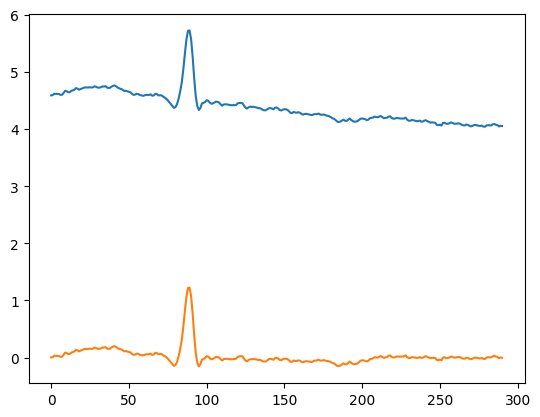

Running FIR fiter on the test set. This will take a while (2h)...
(FIR) Filtering signal 1 of 13316
(FIR) Filtering signal 2 of 13316
(FIR) Filtering signal 3 of 13316
(FIR) Filtering signal 4 of 13316
(FIR) Filtering signal 5 of 13316
(FIR) Filtering signal 6 of 13316
(FIR) Filtering signal 7 of 13316
(FIR) Filtering signal 8 of 13316
(FIR) Filtering signal 9 of 13316
(FIR) Filtering signal 10 of 13316
(FIR) Filtering signal 11 of 13316
(FIR) Filtering signal 12 of 13316
(FIR) Filtering signal 13 of 13316
(FIR) Filtering signal 14 of 13316
(FIR) Filtering signal 15 of 13316
(FIR) Filtering signal 16 of 13316
(FIR) Filtering signal 17 of 13316
(FIR) Filtering signal 18 of 13316
(FIR) Filtering signal 19 of 13316
(FIR) Filtering signal 20 of 13316
(FIR) Filtering signal 21 of 13316
(FIR) Filtering signal 22 of 13316
(FIR) Filtering signal 23 of 13316
(FIR) Filtering signal 24 of 13316
(FIR) Filtering signal 25 of 13316
(FIR) Filtering signal 26 of 13316
(FIR) Filtering signal 27 of 1331

<Figure size 640x480 with 0 Axes>

In [8]:
# -*- coding: utf-8 -*-
# ============================================================
#
#  BWL FIR Filtering
#  authors: David Castro Piñol, Francisco Perdigon Romero
#  email: davidpinyol91@gmail.com, fperdigon88@gmail.com
#  github id: Dacapi91, fperdigon
#
# ============================================================

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter
from datetime import datetime
import _pickle as pickle
from Data_Preparation.data_preparation import Data_Preparation

def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


if __name__ == "__main__":
    # signal for demonstration.
    ecgy = sio.loadmat('digitalFilters/ecgbeat.mat')
    signal = ecgy['ecgy']
    signal = list(signal[:,0])
    ## parameters
    Fs = 360
    Fc = 0.67
    factor = 2

    #ECG_Clean,N = FIRRemoveBL(signal,Fs,Fc,factor)

    ECG_Clean = IIRRemoveBL(signal,Fs, Fc)
    Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test = Data_Preparation(samples=512)
    X_train, y_train, X_test, y_test = Dataset
    plt.figure()
    plt.plot(signal[0:len(ecgy['ecgy'])])
    plt.plot(ECG_Clean)
    plt.show()
    plt.figure()
# Classical Filters
    train_time_list = []
    test_time_list = []
    # FIR
    print('Running FIR fiter on the test set. This will take a while (2h)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = FIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_FIR = [X_test_f, y_test_f, y_filter]

    # Save FIR filter results
    with open('test_results_FIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_FIR, output)
    print('Results from experiment FIR filter saved')

    # IIR
    print('Running IIR fiter on the test set. This will take a while (25 mins)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = IIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_IIR = [X_test_f, y_test_f, y_filter]

    # Save IIR filter results
    with open('test_results_IIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_IIR, output)
    print('Results from experiment IIR filter saved')

    # Saving timing list
    timing = [train_time_list, test_time_list]
    with open('timing.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(timing, output)
    print('Timing saved')

In [ ]:
import shap
import numpy as np
from deepFilter.dl_models import Transformer_COMBDAE
from Data_Preparation.data_preparation import Data_Preparation
from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier
from Data_Preparation.data_preparation_only_fourier import Data_Preparation_only_Fourier
# from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Wavelet
from digitalFilters.dfilters import FIR_test_Dataset, IIR_test_Dataset
from deepFilter.dl_pipeline import train_dl, test_dl
from sklearn.preprocessing import MinMaxScaler
Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test = Data_Preparation_with_Fourier(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset
# 모델 정의 및 가중치 로드
with open('1207/test_results_' + dl_experiments[7] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
    
model = Transformer_COMBDAE()


# 가중치 로드
model_filepath = "/home/dhc99/ecg_denoise/1207/Transformer_COMBDAE_weights.best.weights.h5"
model.load_weights(model_filepath)

# 데이터 스케일링
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
F_test_x_scaled = scaler.fit_transform(F_test_x.reshape(-1, F_test_x.shape[-1])).reshape(F_test_x.shape)


# SHAP Explainer 정의
explainer = shap.Explainer(model.predict, [X_test_scaled, F_test_x_scaled])

# 샘플 데이터 선택 (테스트 데이터의 첫 500개 샘플)
num_samples = 500
X_test_sample = X_test_scaled[:num_samples]
F_test_sample = F_test_x_scaled[:num_samples]

# SHAP Value 계산
shap_values = explainer([X_test_sample, F_test_sample], max_evals=2049)

# SHAP Value 분리
shap_values_time = shap_values[0].values  # Time Domain SHAP Values
shap_values_freq = shap_values[1].values  # Frequency Domain SHAP Values

# SHAP Value 시각화
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Time Domain SHAP Value Heatmap
shap.summary_plot(shap_values_time, X_test_sample, feature_names=["Time_" + str(i) for i in range(X_test_sample.shape[1])],
                  plot_type="heatmap", max_display=50, show=False)
ax[0].set_title("Time Domain SHAP Values")

# Frequency Domain SHAP Value Heatmap
shap.summary_plot(shap_values_freq, F_test_sample, feature_names=["Freq_" + str(i) for i in range(F_test_sample.shape[1])],
                  plot_type="heatmap", max_display=50, show=False)
ax[1].set_title("Frequency Domain SHAP Values")

plt.tight_layout()
plt.show()

# 특정 주파수 대역 기여도 분석 (Frequency Band Importance)
frequency_bands = [(0, 5), (5, 10), (10, 20), (20, 50)]  # Example bands in Hz
band_importance = []
for band in frequency_bands:
    start, end = band
    indices = [i for i in range(len(F_test_sample[0])) if start <= i < end]
    band_shap_values = shap_values_freq[:, indices].mean(axis=1)
    band_importance.append(band_shap_values.mean())

# Frequency Band Importance 시각화
plt.bar(range(len(frequency_bands)), band_importance, tick_label=[f"{b[0]}-{b[1]} Hz" for b in frequency_bands])
plt.ylabel("Mean SHAP Value")
plt.xlabel("Frequency Band")
plt.title("Frequency Band Importance")
plt.show()

